#### **NEM Review contract co-design workshop**

# Wind and solar risk profiles

Analyses of individual generators' dispatch-weighted average prices, curtailment and underperformance.

## Prepare data

In [1]:
# Data handling
import geopandas as gpd
import numpy as np
import os
import pandas as pd
import pyarrow.compute as pc

# Visualisation
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Custom functions
from scripts.common_functions import python_setup, get_mms_data, save_figure

# Set up Python
working_dir, charts_dir, data_dir = python_setup(2, dark_mode=False)

# Paths and variables
gen_info_path = os.path.join(data_dir, "gen_info.csv")
duid_data_path = os.path.join(data_dir, "duid_data.parquet")
market_data_path = os.path.join(data_dir, "market_data.parquet")
regions = ["NSW", "QLD", "SA", "VIC"]

# Load gen info
gen_info = pd.read_csv(
    gen_info_path,
    index_col="DUID")

## Dispatch-weighted average prices

Calculate DWA prices by day, week and quarter.

In [2]:
# Prepare DWA prices
for i, region in enumerate(regions):
    print(f"Preparing {region} dispatch-weighted average prices ...")
    # Prepare DUID data
    region_duids = gen_info[gen_info["Region"] == region].index.tolist()
    region_duid_data = pd.read_parquet(
        duid_data_path,
        engine="pyarrow",
        filters=[("DUID", "in", region_duids)],
        columns=["DUID", "Interval", "Output"])
    # Attach 'technology' to DUID data
    region_duid_data["Technology"] = gen_info.loc[
        region_duid_data["DUID"],
        "Technology"].values
    # Prepare market data
    region_market_data = pd.read_parquet(
        market_data_path,
        engine="pyarrow",
        filters=[("Region", "==", region)],
        columns=["Interval", "Price"]).set_index("Interval")
    # Merge price and generation data
    region_duid_data["Price"] = region_market_data.loc[region_duid_data["Interval"], "Price"].values
    region_duid_data["Revenue"] = region_duid_data["Output"] * region_duid_data["Price"]    
    region_dwa_prices = region_duid_data.pivot_table(
        index="Interval",
        columns=["Technology", "DUID"],
        values=["Revenue", "Output"])
    # Quarterly DWA prices
    region_dwa_prices_qtr = region_dwa_prices.resample("QE")["Revenue"].sum() / region_dwa_prices.resample("QE")["Output"].sum()
    region_dwa_prices_qtr.index.name = "Quarter"
    region_dwa_prices_qtr.to_csv(os.path.join(data_dir, f"{region}_duid_dwa_prices_quarterly.csv"))
    # Weekly DWA prices
    region_dwa_prices_wk = region_dwa_prices.resample("W")["Revenue"].sum() / region_dwa_prices.resample("W")["Output"].sum()
    region_dwa_prices_wk.index.name = "Week"
    region_dwa_prices_wk.to_csv(os.path.join(data_dir, f"{region}_duid_dwa_prices_weekly.csv"))
    # Daily DWA prices
    region_dwa_prices_daily = region_dwa_prices.resample("D")["Revenue"].sum() / region_dwa_prices.resample("D")["Output"].sum()
    region_dwa_prices_daily.index.name = "Date"
    region_dwa_prices_daily.to_csv(os.path.join(data_dir, f"{region}_duid_dwa_prices_daily.csv"))

del region_duid_data, region_market_data, region_dwa_prices_qtr, region_dwa_prices_wk, region_dwa_prices_daily

Preparing NSW dispatch-weighted average prices ...
Preparing QLD dispatch-weighted average prices ...
Preparing SA dispatch-weighted average prices ...
Preparing VIC dispatch-weighted average prices ...


## DWA and TWA price charts

NSW


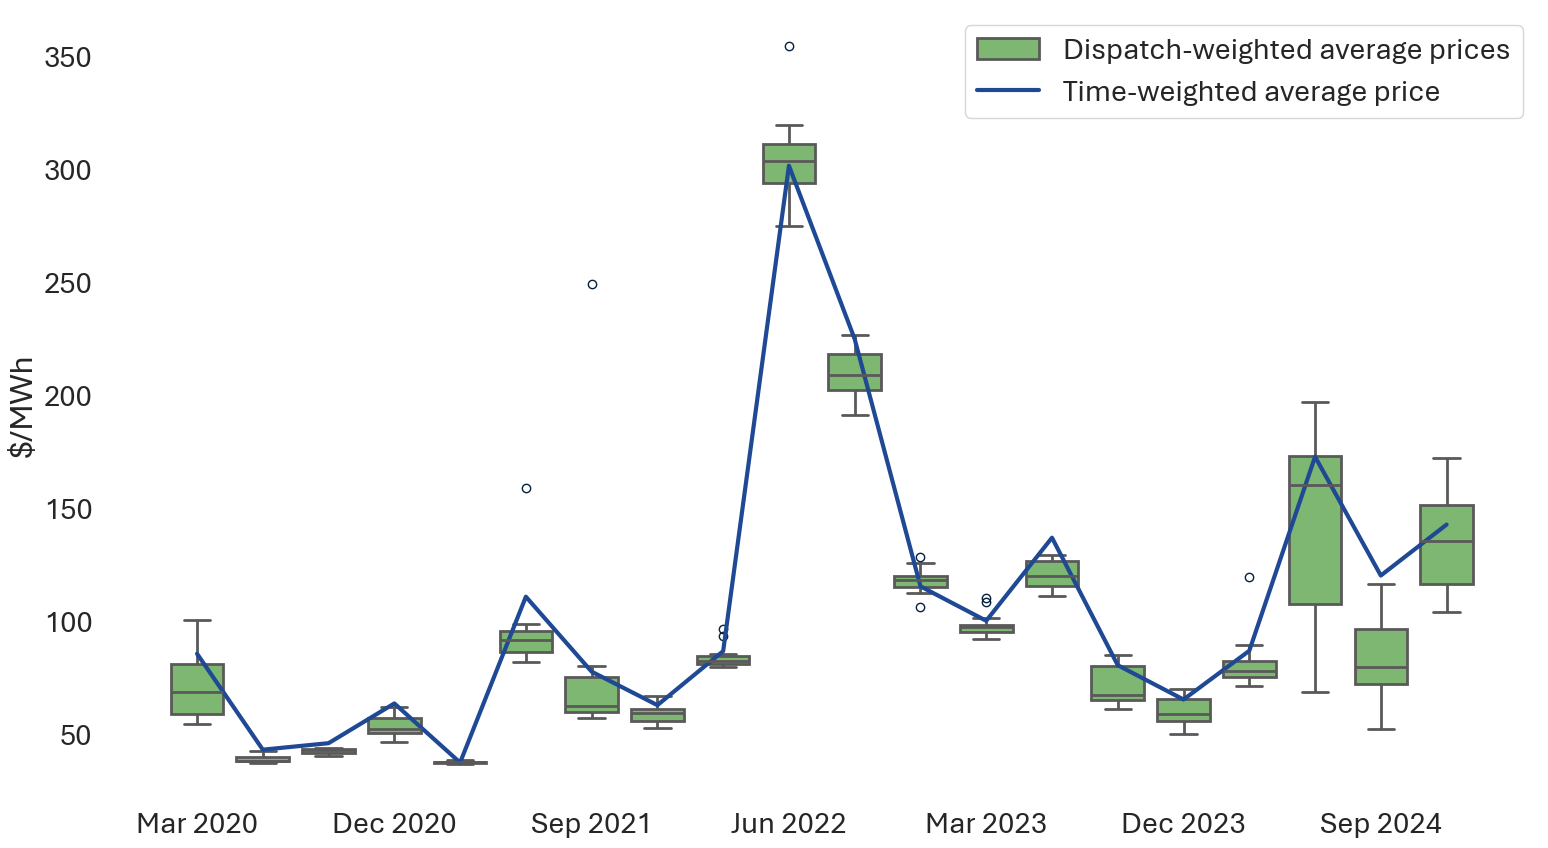

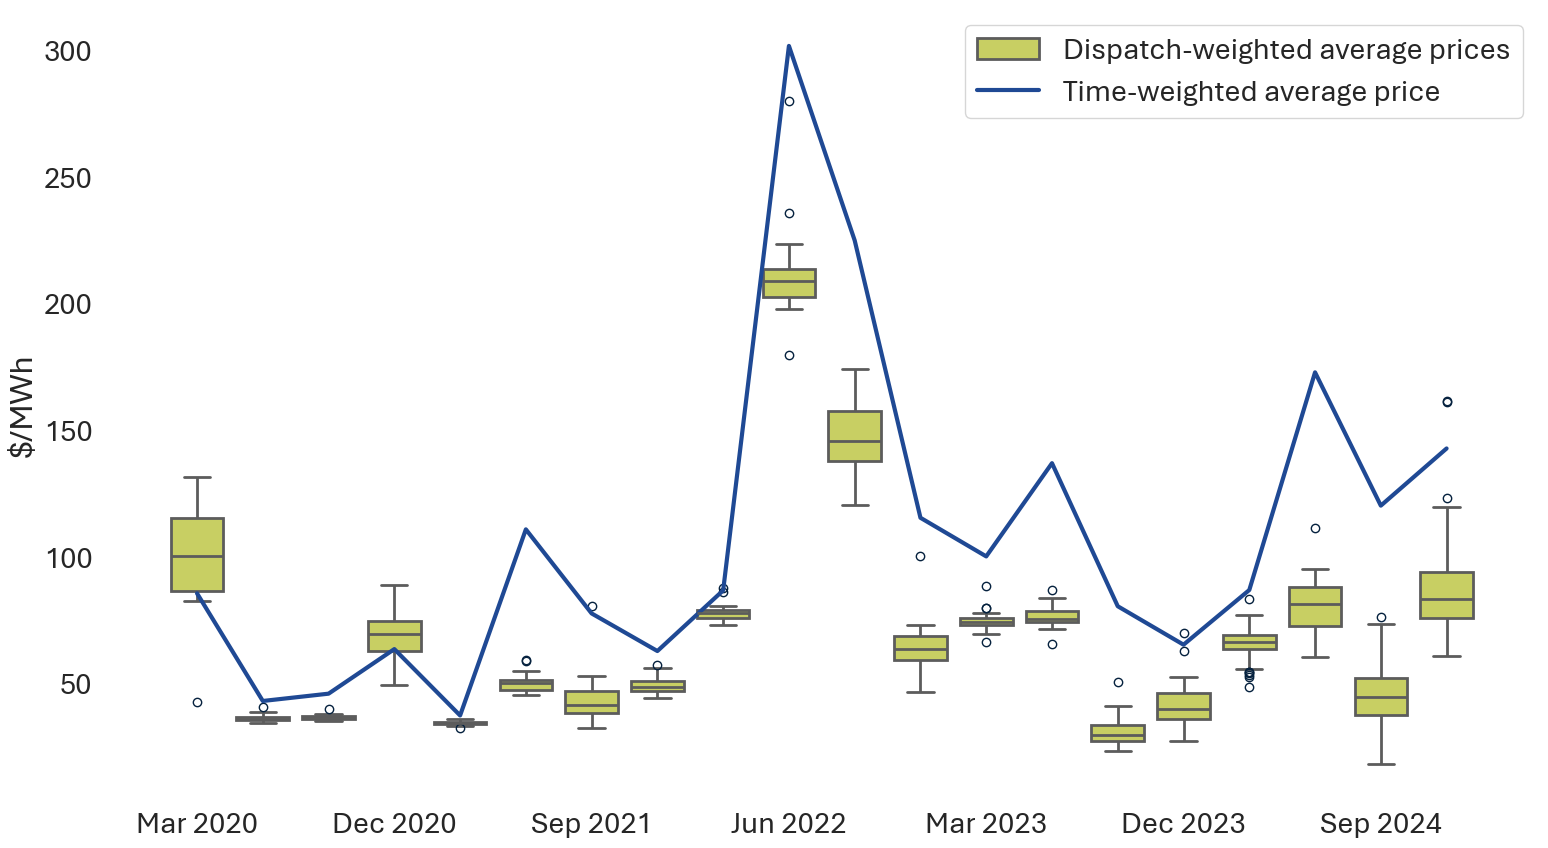

QLD


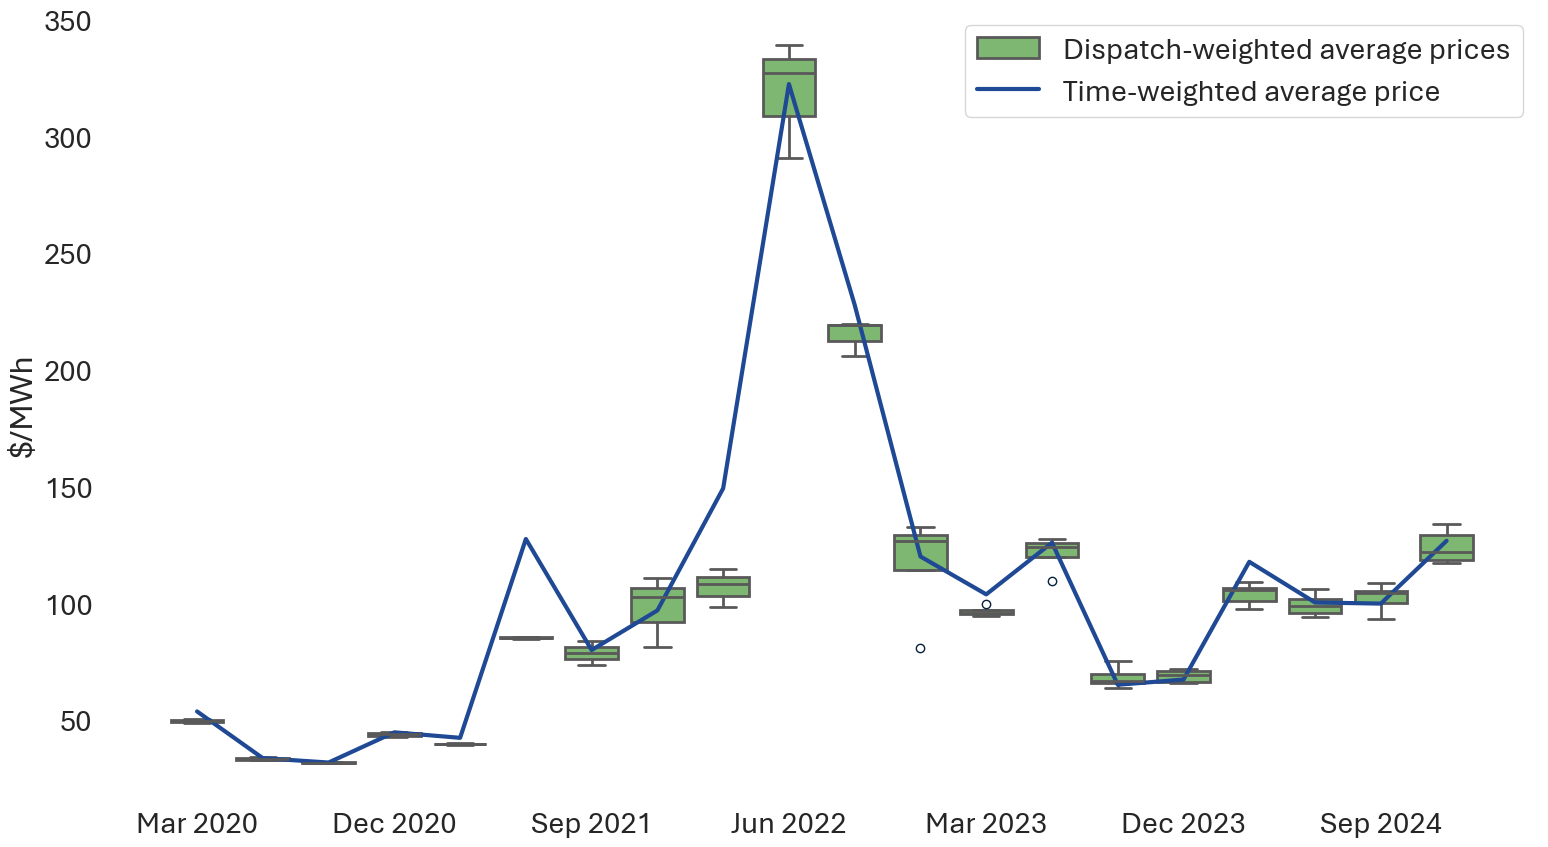

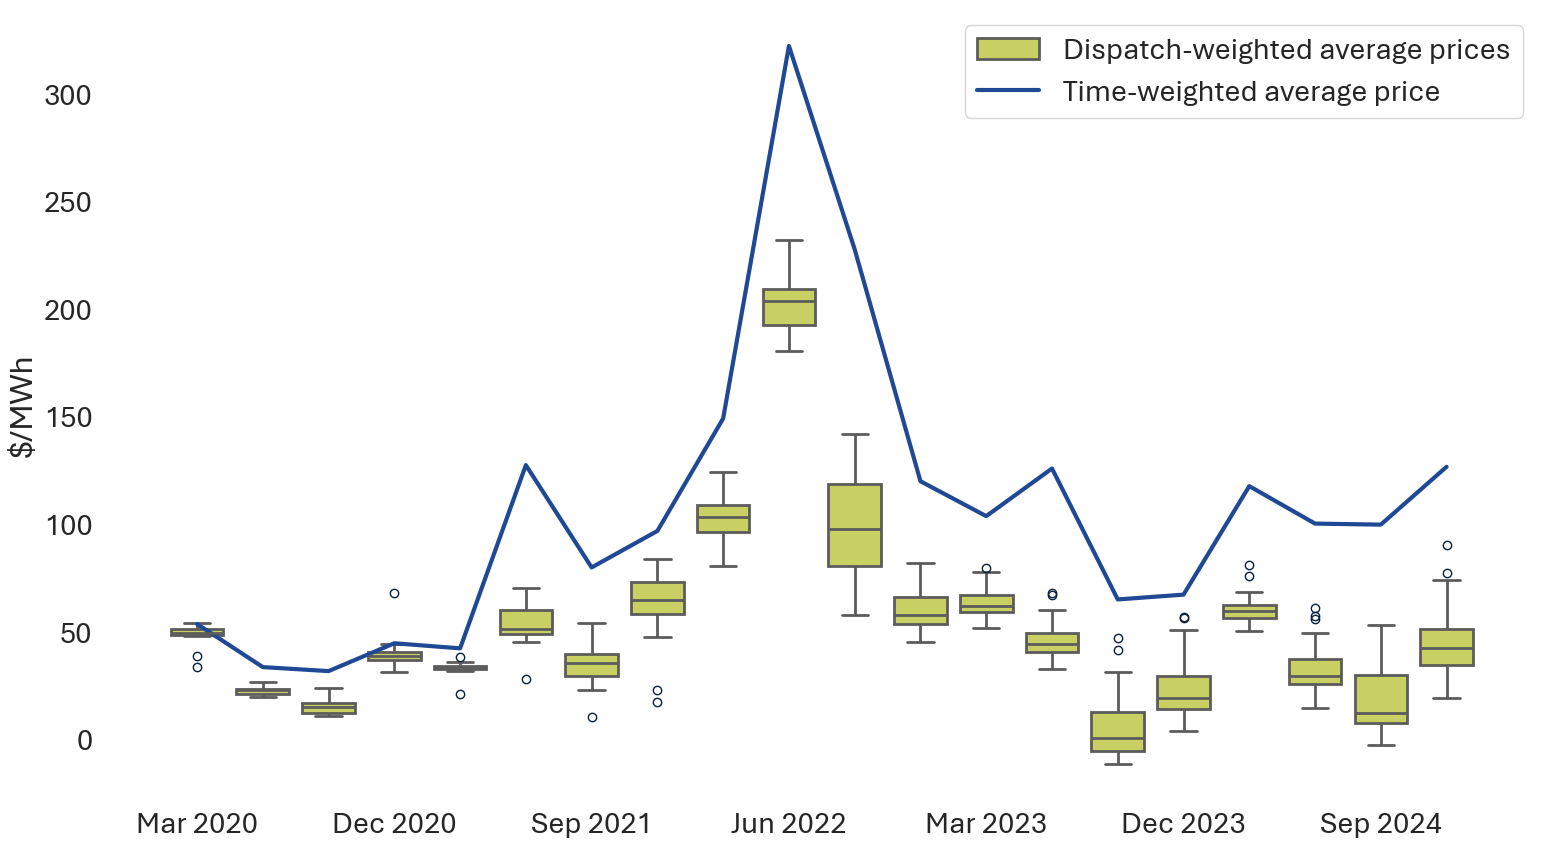

SA


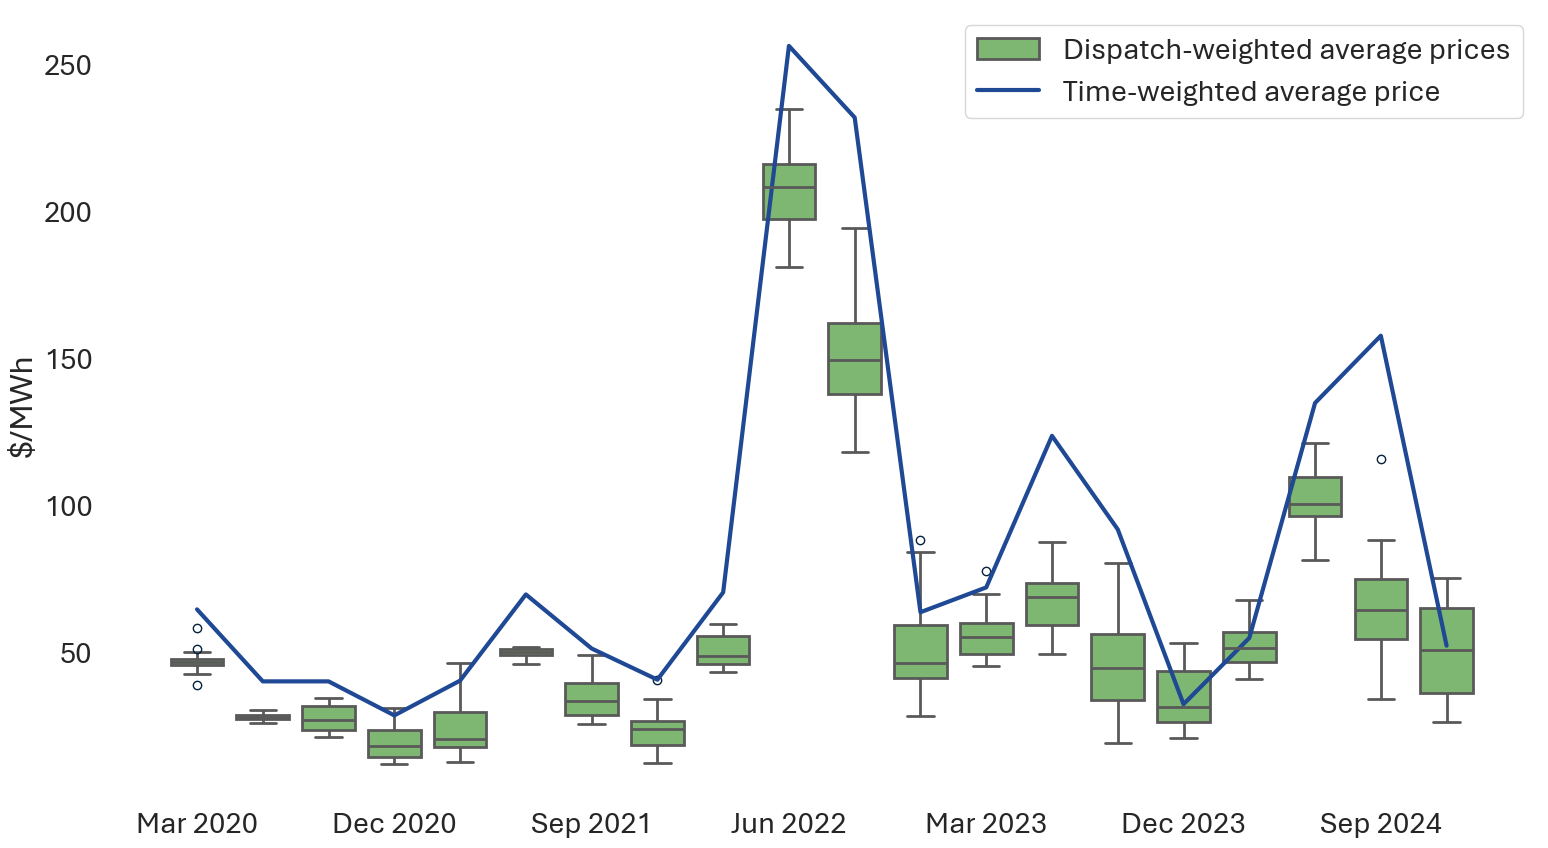

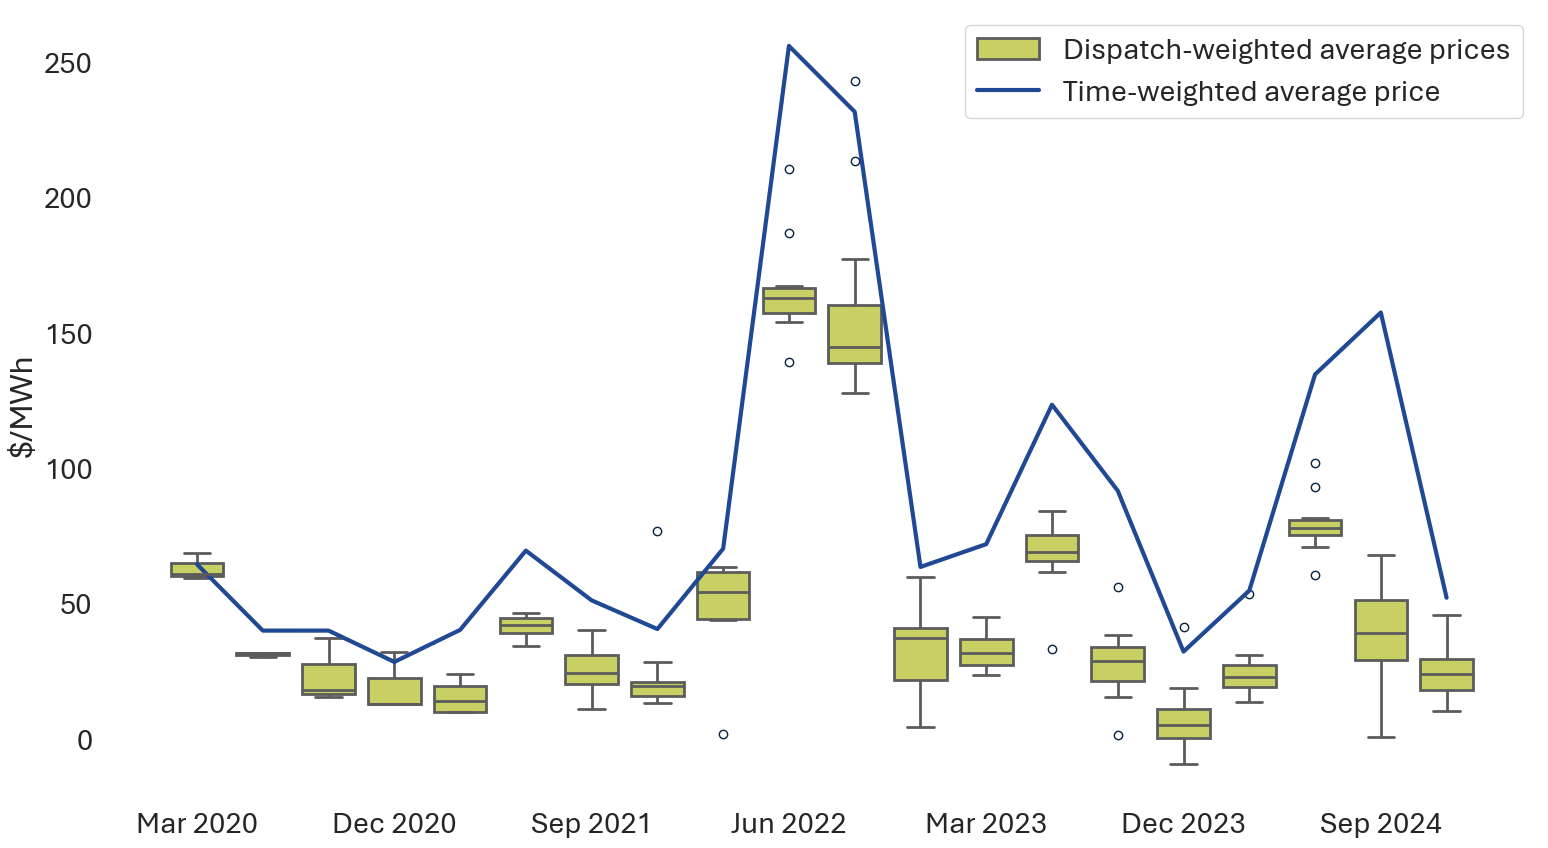

VIC


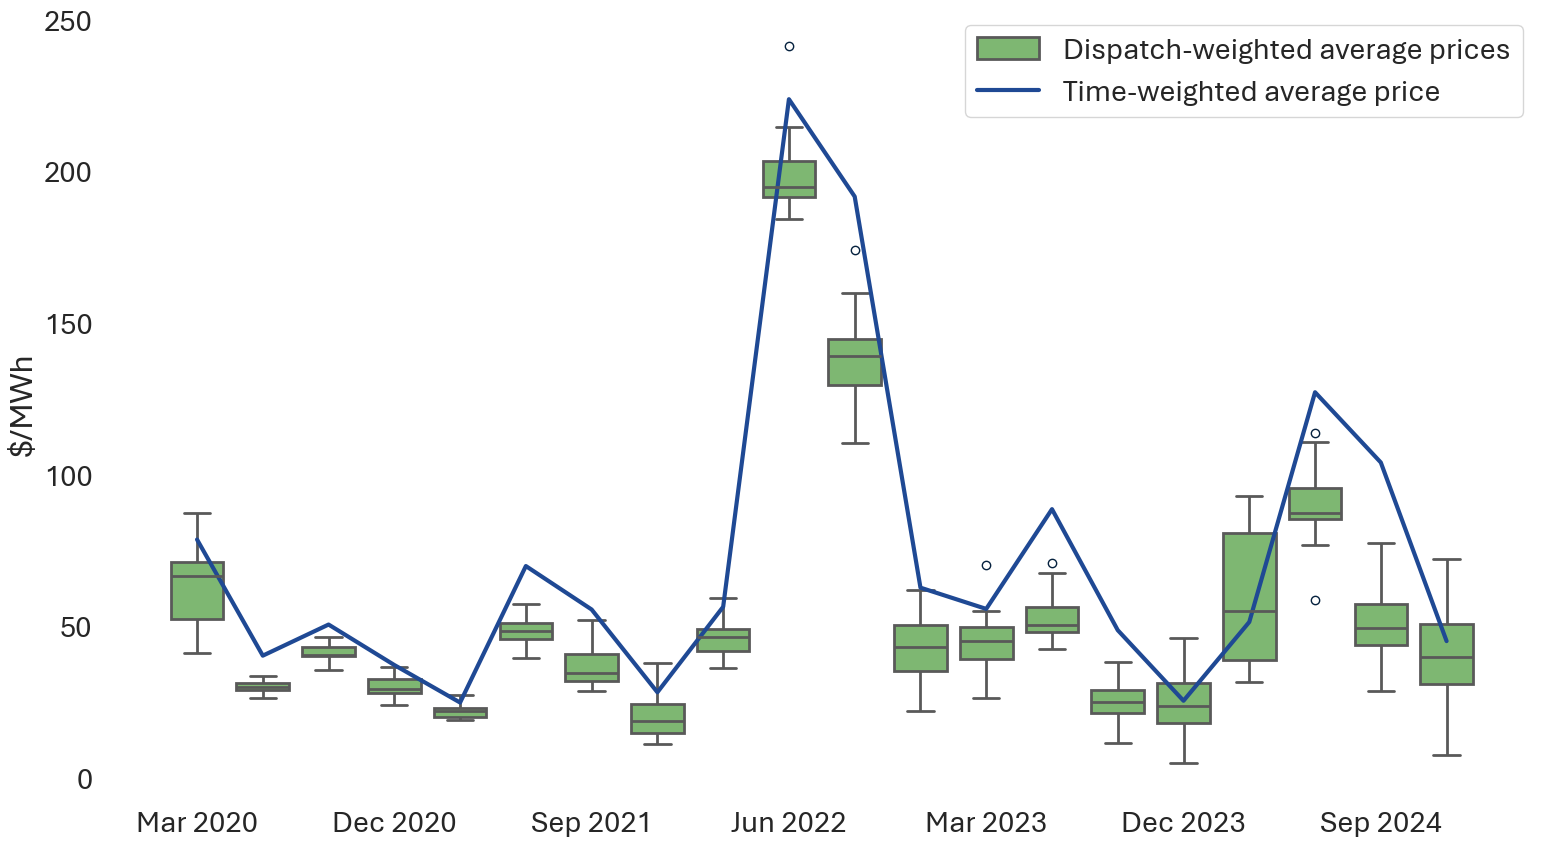

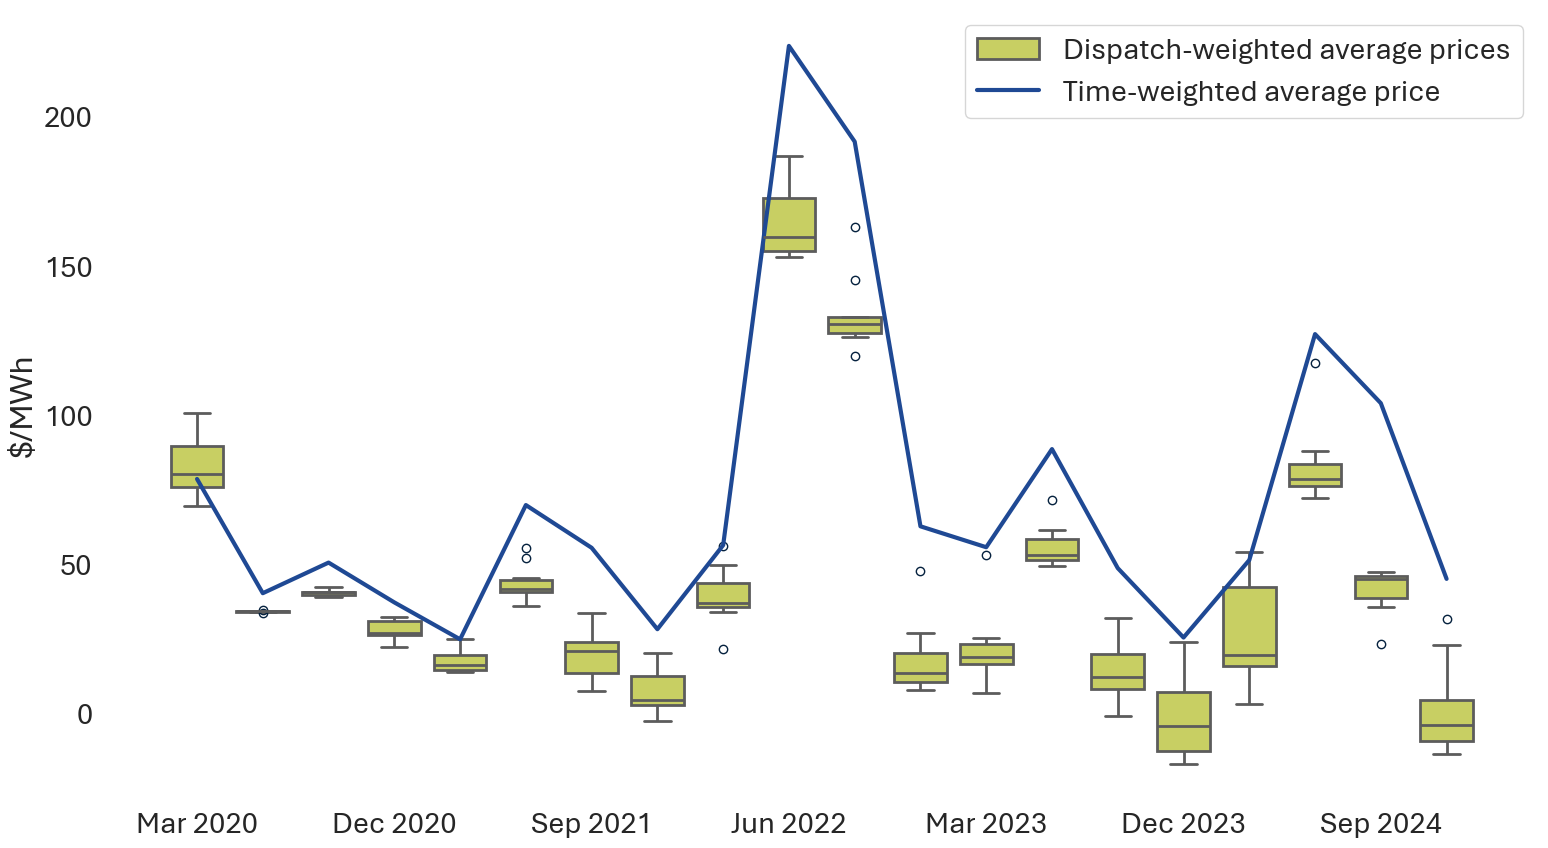

In [3]:
for i, region in enumerate(regions):
    print(region)
    # Load and prepare DWA data
    region_dwas = pd.read_csv(
        os.path.join(data_dir, f"{region}_duid_dwa_prices_quarterly.csv"),
        header=[0, 1],
        parse_dates=[0],
        index_col=0)
    quarters = region_dwas.index

    # Filter out invalid sequences
    first_row = region_dwas.iloc[0]
    region_dwas_valid = region_dwas.shift(1).notna()
    region_dwas = region_dwas.where(region_dwas_valid)
    region_dwas.iloc[0] = first_row

    for tech in ["Wind", "Solar"]:
        # Melt for boxplot
        box_data = region_dwas[tech].reset_index().melt(
            id_vars="Quarter",
            var_name="DUID",
            value_name="DWA price")

        # Load and prepare TWA data
        twa_data = pd.read_parquet(
            market_data_path,
            filters=[("Region", "==", region)],
            columns=["Interval", "Price"]
        ).set_index("Interval")

        # Resample to quarterly
        twa_quarterly = twa_data.resample("QE").mean()
        twa_quarterly.index = range(len(twa_quarterly))

        # Create plot
        fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)

        # Create boxplot
        sns.boxplot(
            ax=ax,
            data=box_data,
            x="Quarter",
            y="DWA price",
            color=("C3" if tech == "Wind" else "C4"),
            linewidth=2,
            flierprops=dict(markeredgecolor="C0"),
            label="Dispatch-weighted average prices")

        # Plot TWA line
        sns.lineplot(
            x=twa_quarterly.index,        
            y=twa_quarterly["Price"],
            color="C1",
            linewidth=3,
            ax=ax,
            label="Time-weighted average price")

        # Format x-axis
        ax.set_xticks(ax.get_xticks()[::3])
        ax.set_xticklabels([f"{quarters[t]:%b %Y}" for t in ax.get_xticks()])

        # Clean up
        for frame in ["top", "right", "bottom", "left"]:
            ax.spines[frame].set_visible(False)

        ax.set_ylabel("$/MWh")
        ax.set_xlabel(None)
        plt.show()
        save_figure(fig, f"{region}_dwa_twa_{tech.lower()}_quarterly_prices", charts_dir)

## Curtailment charts

Curtailment is defined as:

$$
\text{Curtailment} = \text{max} \left(0, \frac{\text{Availability} - \text{Output}}{\text{Availability}} \right)
$$

NSW


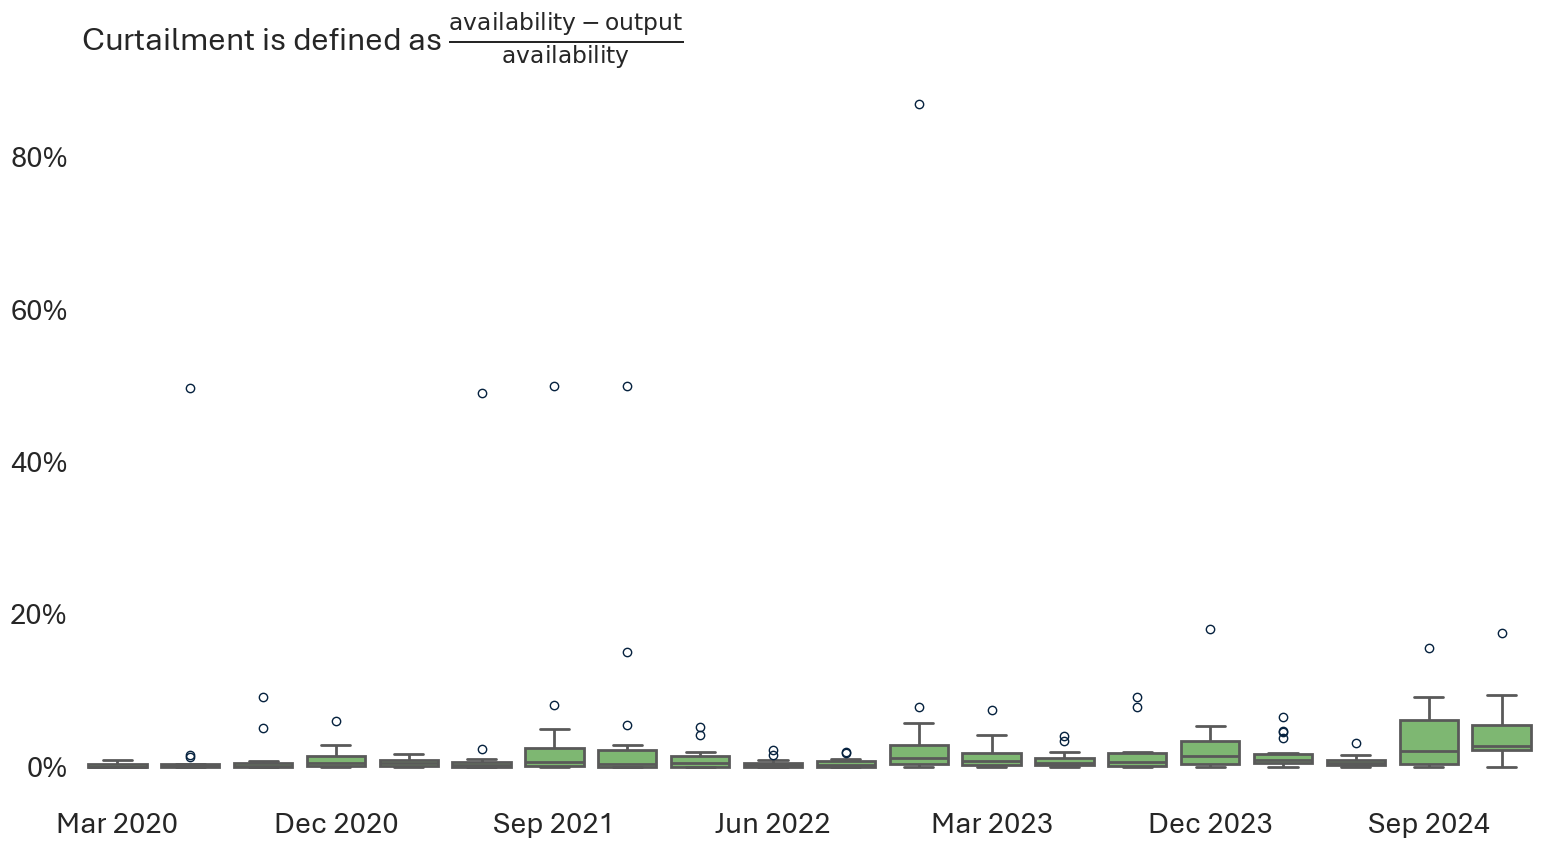

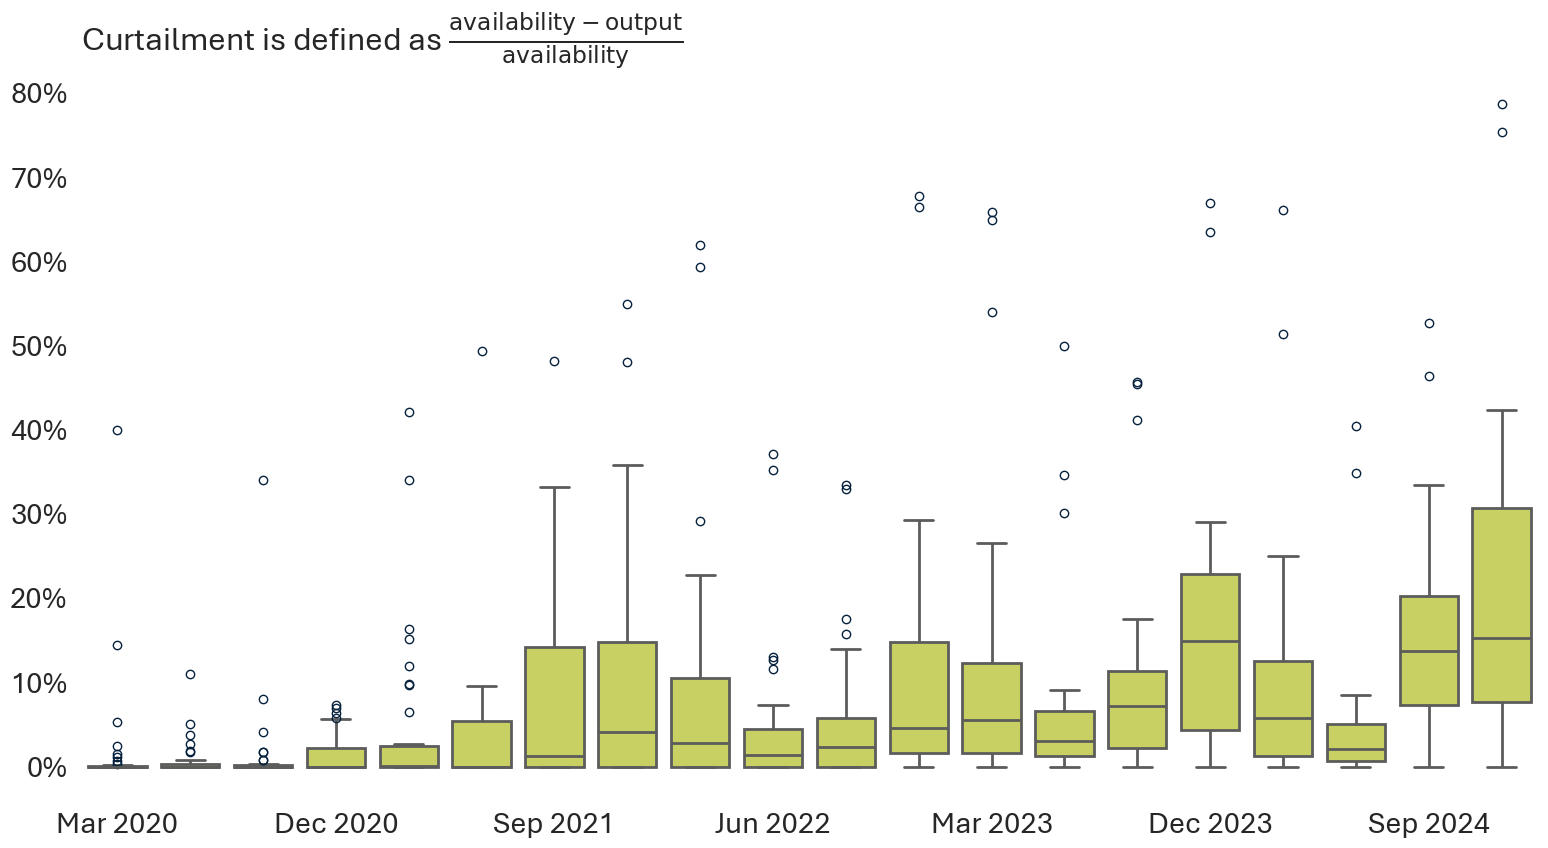

QLD


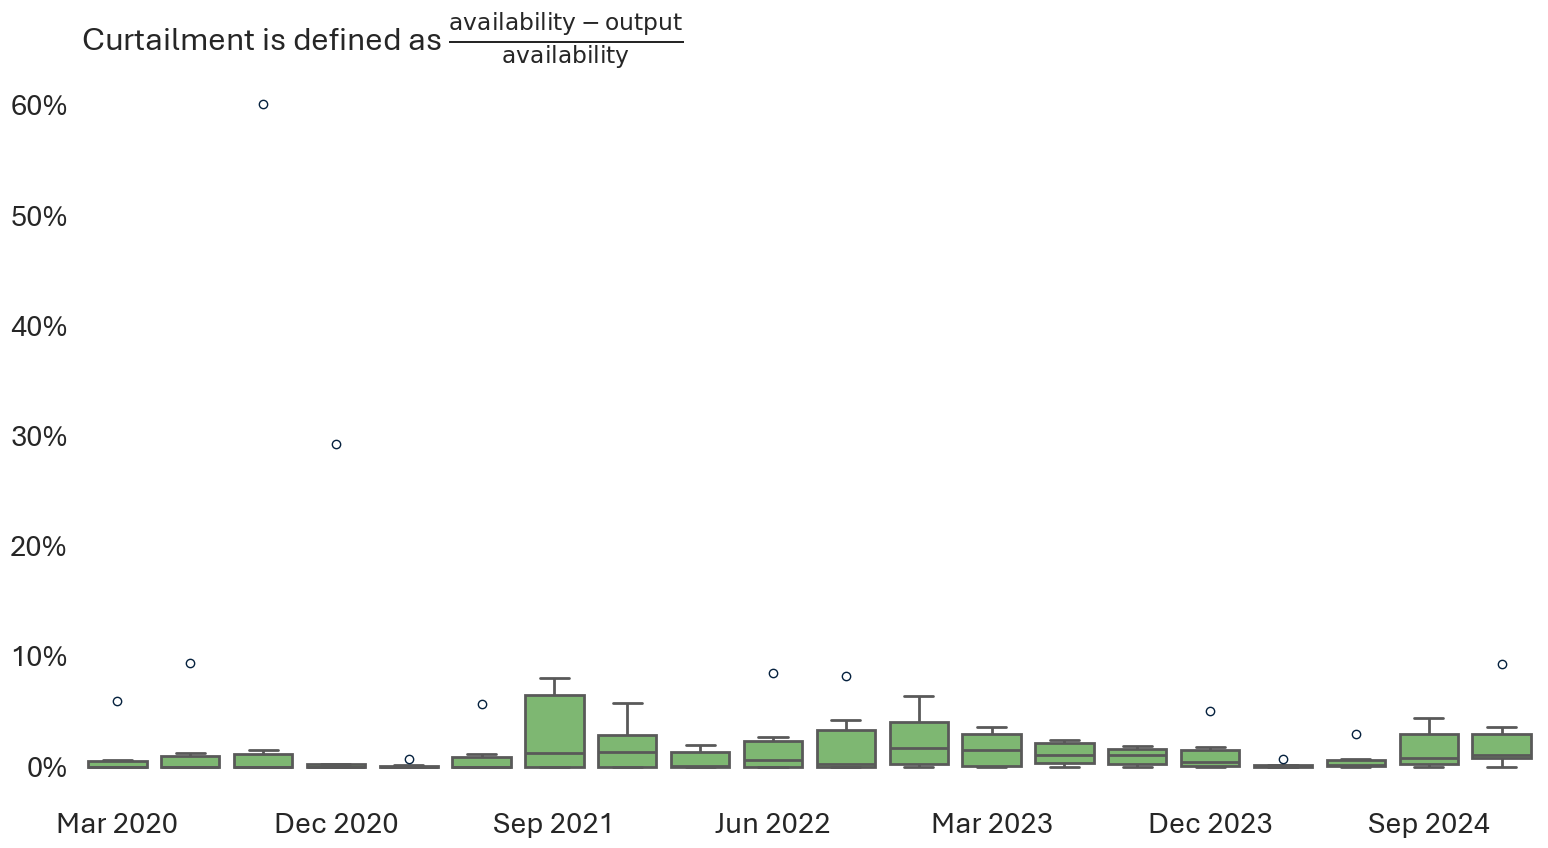

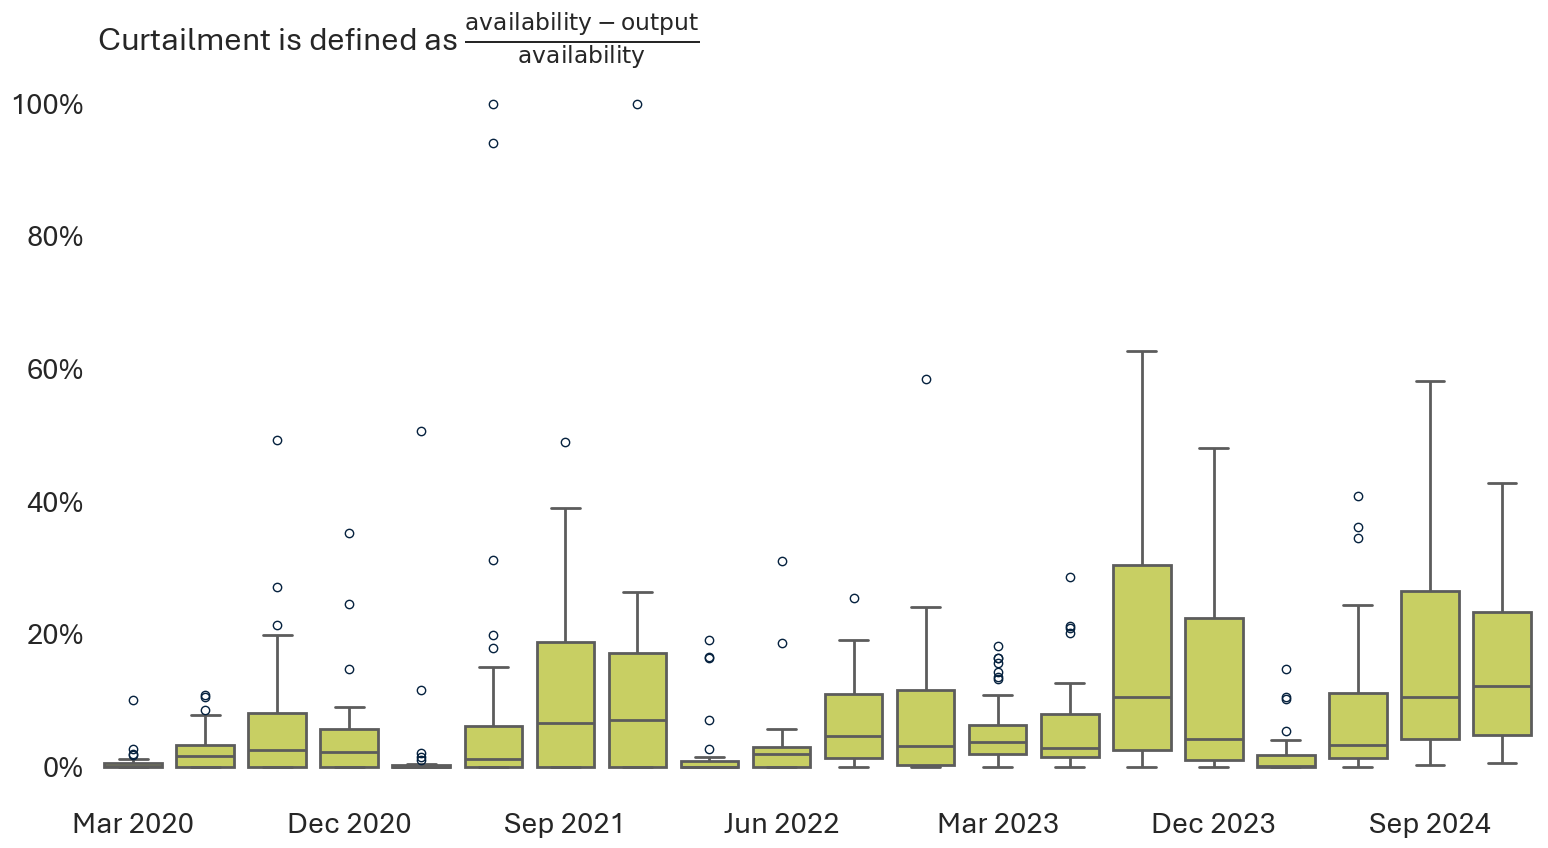

SA


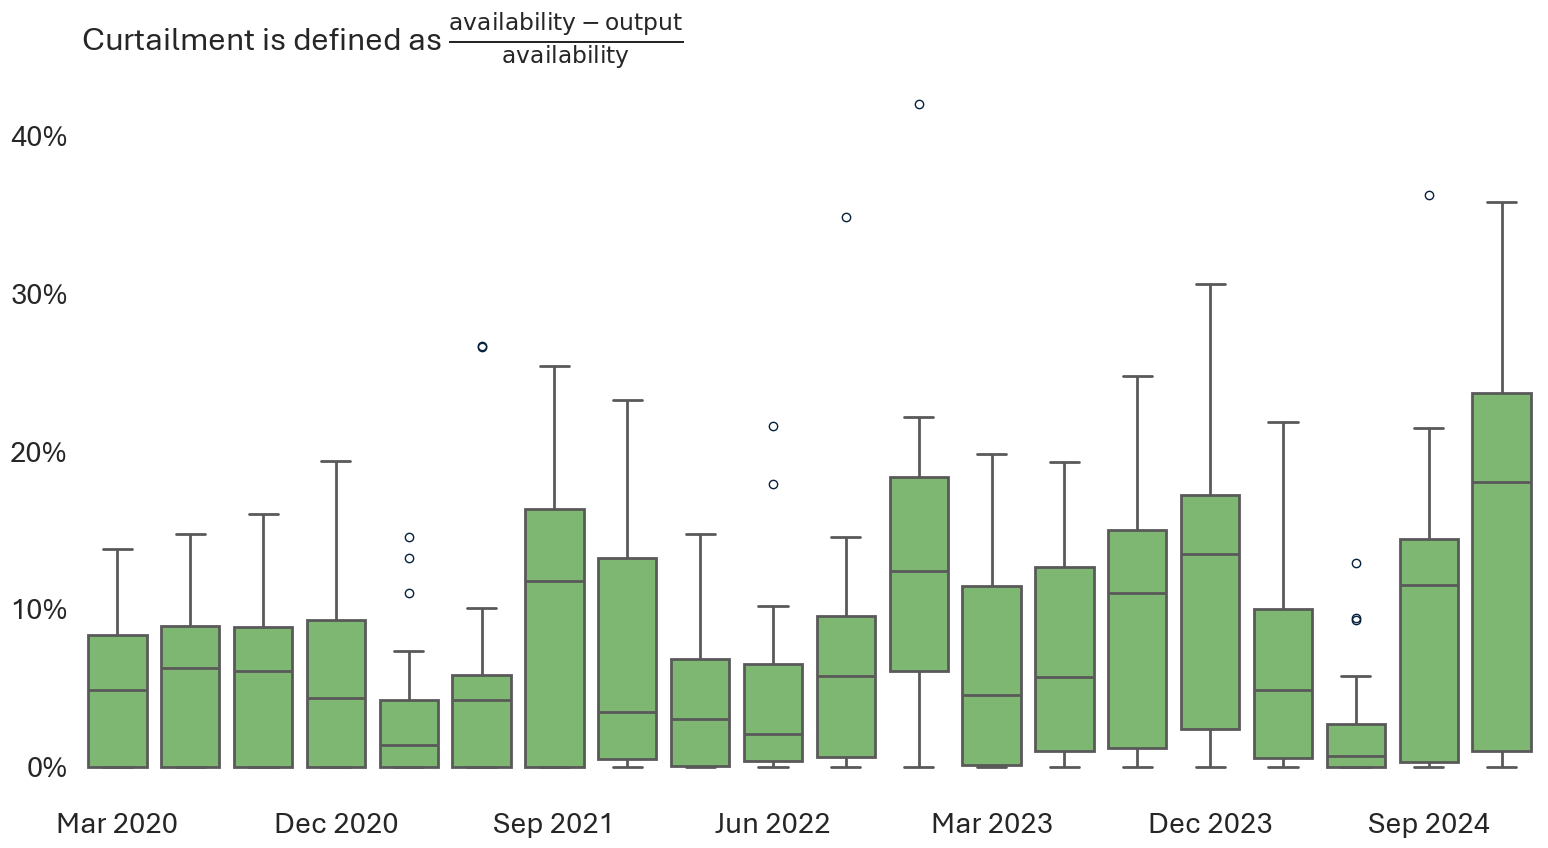

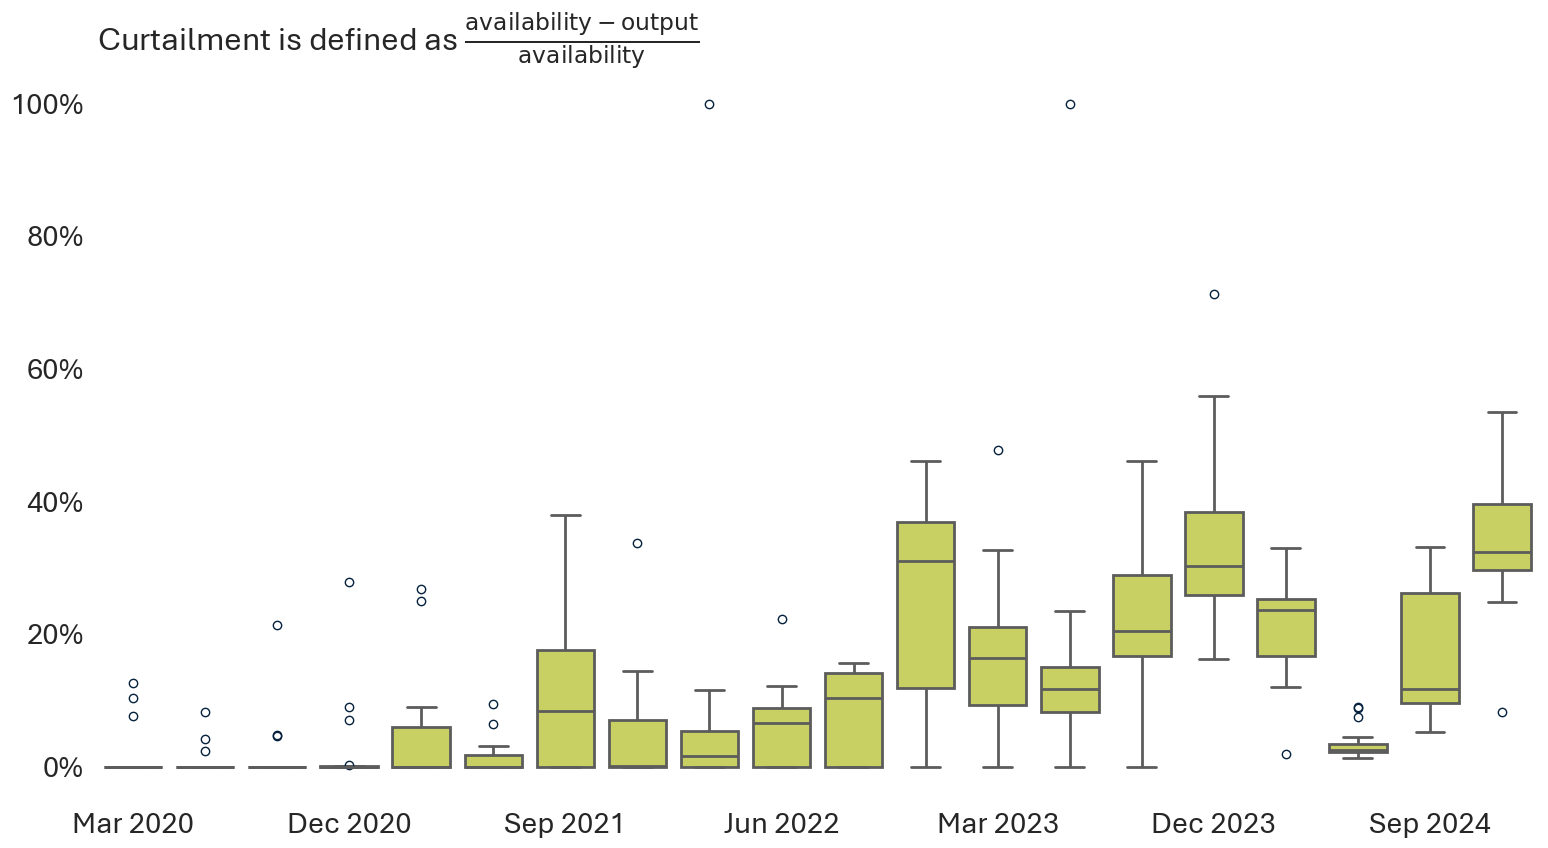

VIC


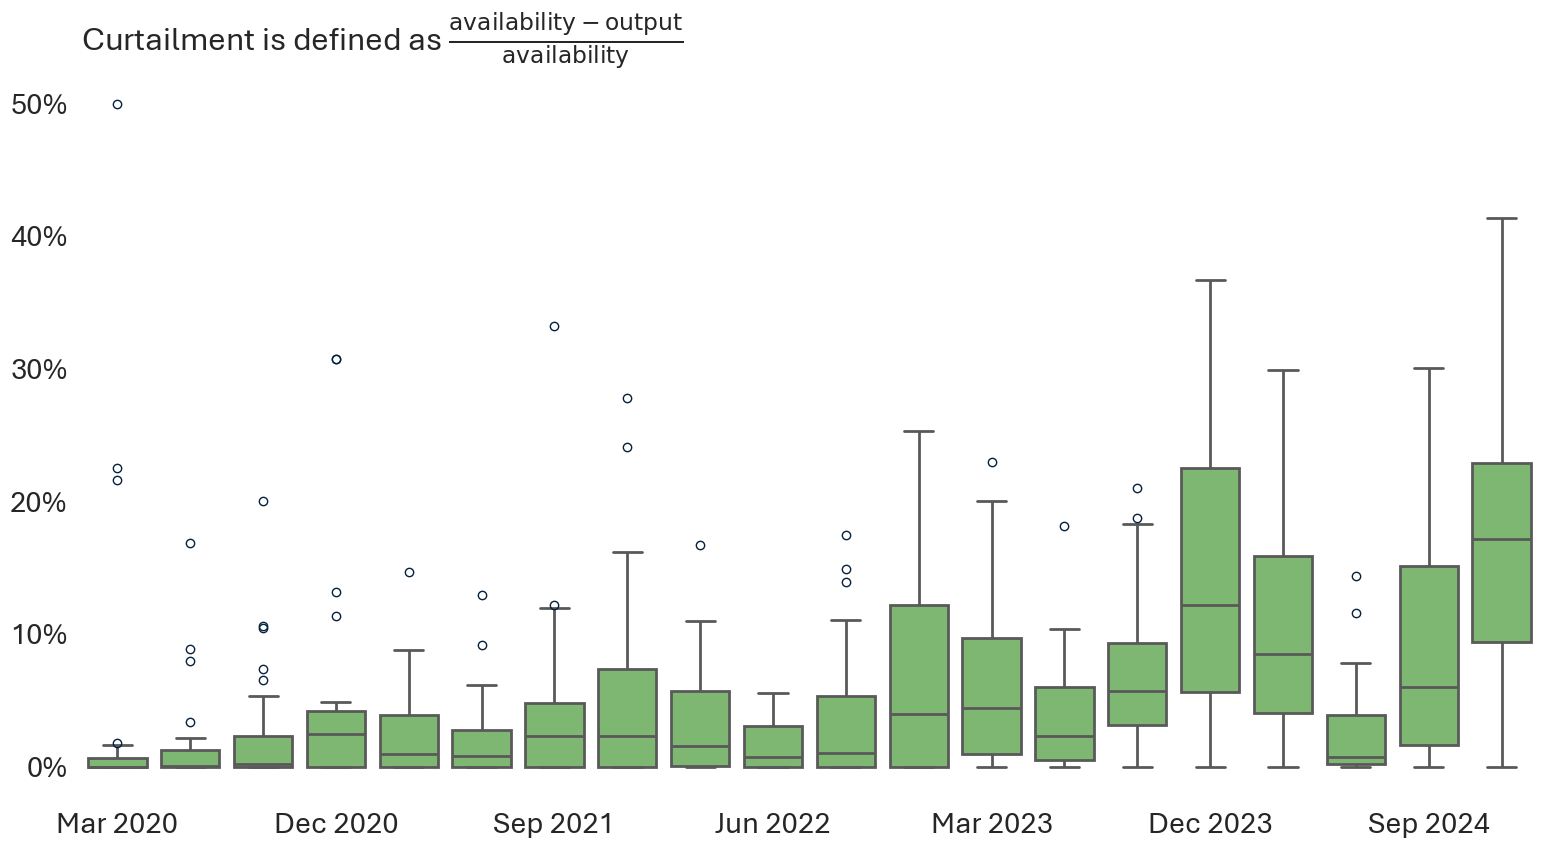

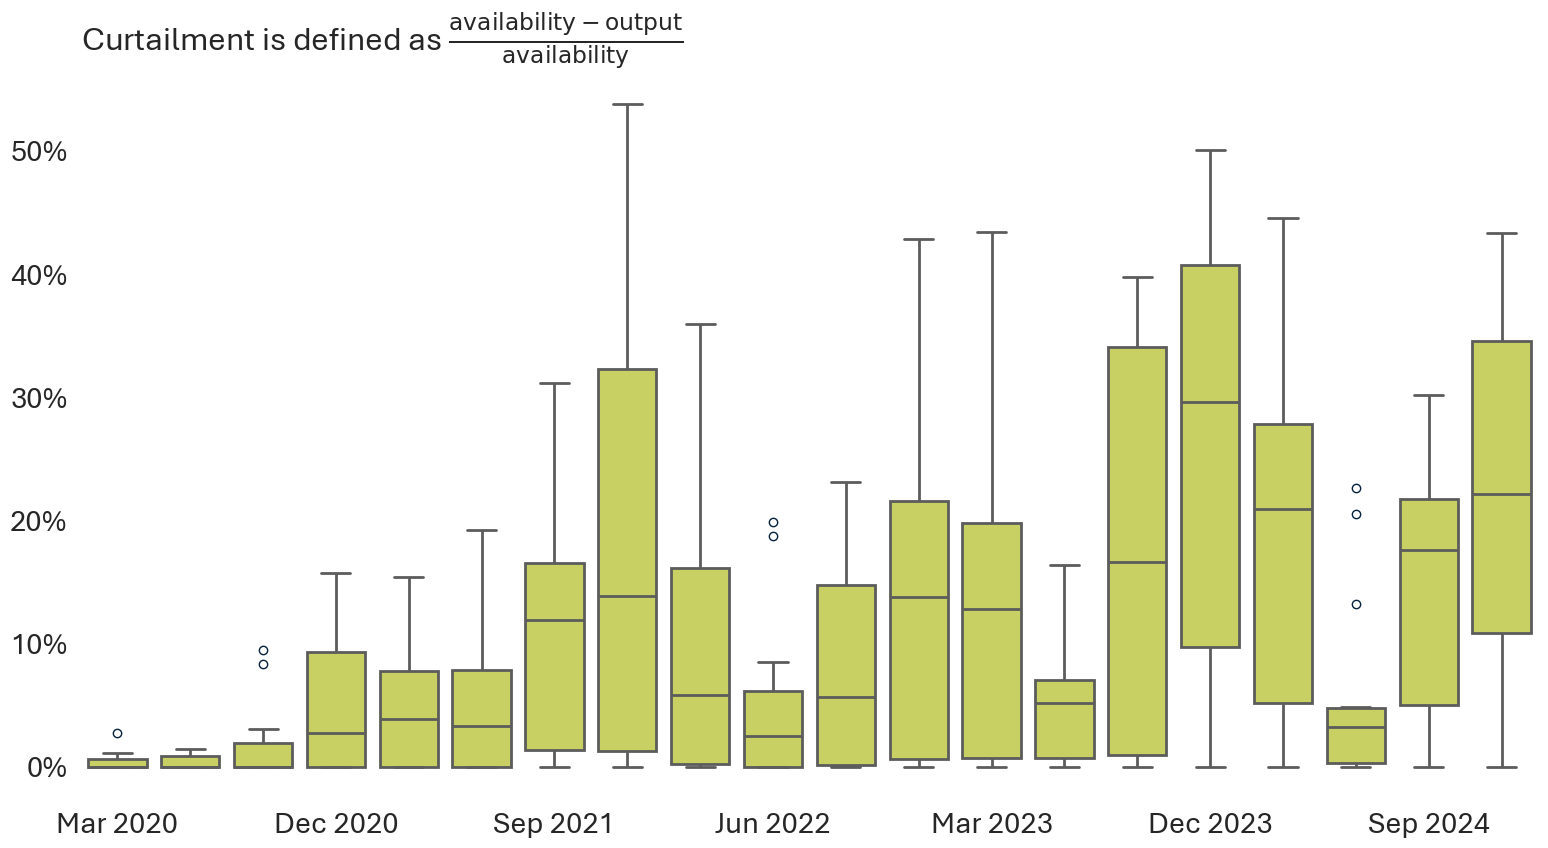

In [4]:
for i, region in enumerate(regions):
    print(region)

    for tech in ["Wind", "Solar"]:
        # Load and prepare curtailment data
        region_duids = gen_info[
            (gen_info["Technology"] == tech) &
            (gen_info["Region"] == region)].index    
        region_data = pd.read_parquet(
            duid_data_path,
            engine="pyarrow",
            filters=[("DUID", "in", region_duids)],
            columns=["Interval", "Output", "Availability", "DUID"])
        region_data = region_data.pivot_table(
            index="Interval",
            columns="DUID",
            values=["Output", "Availability"],
            aggfunc="sum")
        region_data = region_data.resample("QE").sum()
        region_data.index.name = "Quarter"
        quarters = region_data.index
        region_curtailment = (1 - region_data["Output"] / region_data["Availability"]).map(lambda x: max(0, x))
        
        # Filter out invalid sequences
        region_curtailment = region_curtailment.replace([np.inf, -np.inf], np.nan)
        region_curtailment_valid = region_data["Availability"].notna()
        del region_data
        first_row = region_curtailment.iloc[0]
        region_curtailment_valid = region_curtailment.shift(1).notna()
        region_curtailment = region_curtailment.where(region_curtailment_valid)
        region_curtailment.iloc[0] = first_row

        # Melt for boxplot
        box_data = region_curtailment.reset_index().melt(
            id_vars="Quarter",
            var_name="DUID",
            value_name="Curtailment")
        region_curtailment.to_csv(
            os.path.join(data_dir, f"{region}_duid_{tech.lower()}_curtailment_quarterly.csv"))

        # Create plot
        fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)

        # Create boxplot
        sns.boxplot(
            ax=ax,
            data=box_data,
            x="Quarter",
            y="Curtailment",
            color=("C3" if tech == "Wind" else "C4"),
            linewidth=2,
            flierprops=dict(markeredgecolor="C0"))

        # Format axes
        ax.set_xticks(ax.get_xticks()[::3])
        ax.set_xticklabels([f"{quarters[t]:%b %Y}" for t in ax.get_xticks()])
        ax.yaxis.set_major_formatter(lambda x, p: f"{x:.0%}")

        # Clean up
        for frame in ["top", "right", "bottom", "left"]:
            ax.spines[frame].set_visible(False)

        plt.title(r"Curtailment is defined as $\frac{\text{availability} - \text{output}}{\text{availability}}$", loc="left")
        plt.ylabel(None)
        plt.xlabel(None)
        plt.show()
        save_figure(fig, f"{region}_duid_{tech.lower()}_quarterly_curtailment", charts_dir)

## Underperformance charts

Underperformance is the percentage of intervals during the night hours for wind (8pm–6am) or daylight hours for solar (9am–4pm) that the generator is outputting less than 10% of its maximum capacity.

NSW


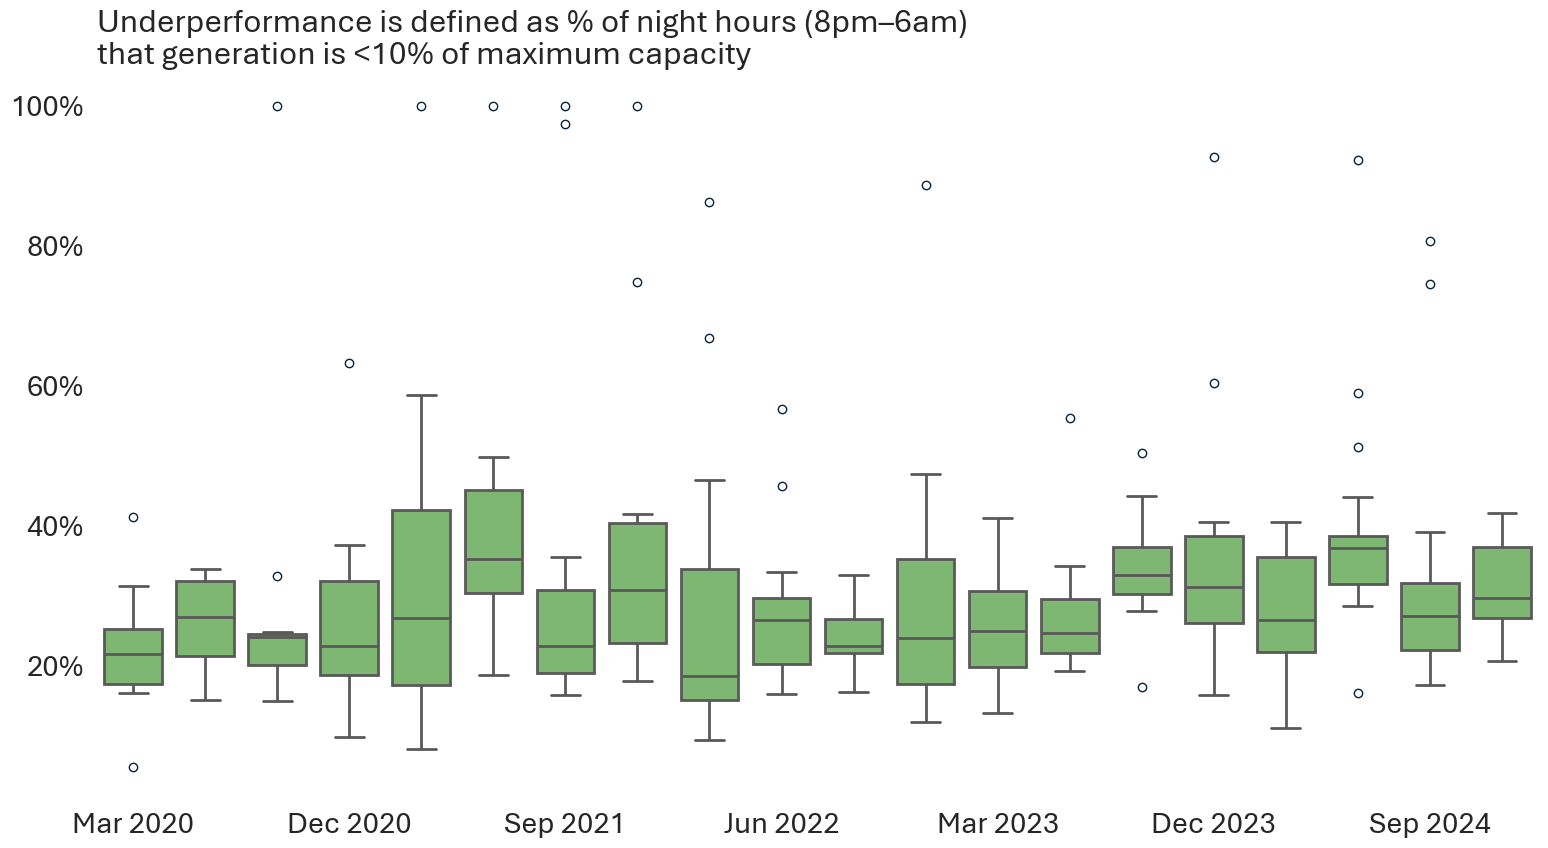

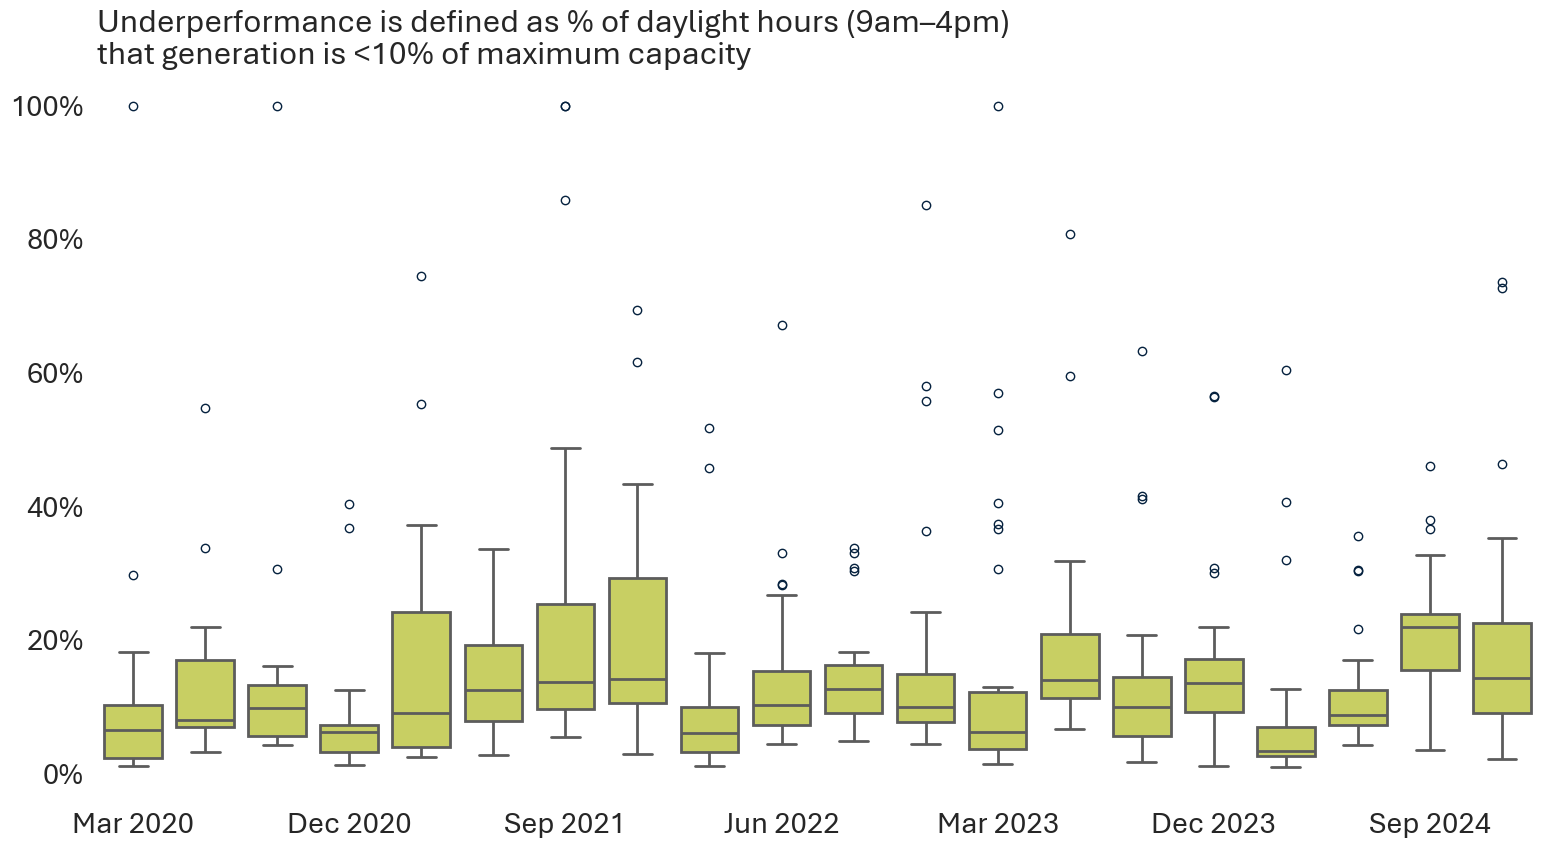

QLD


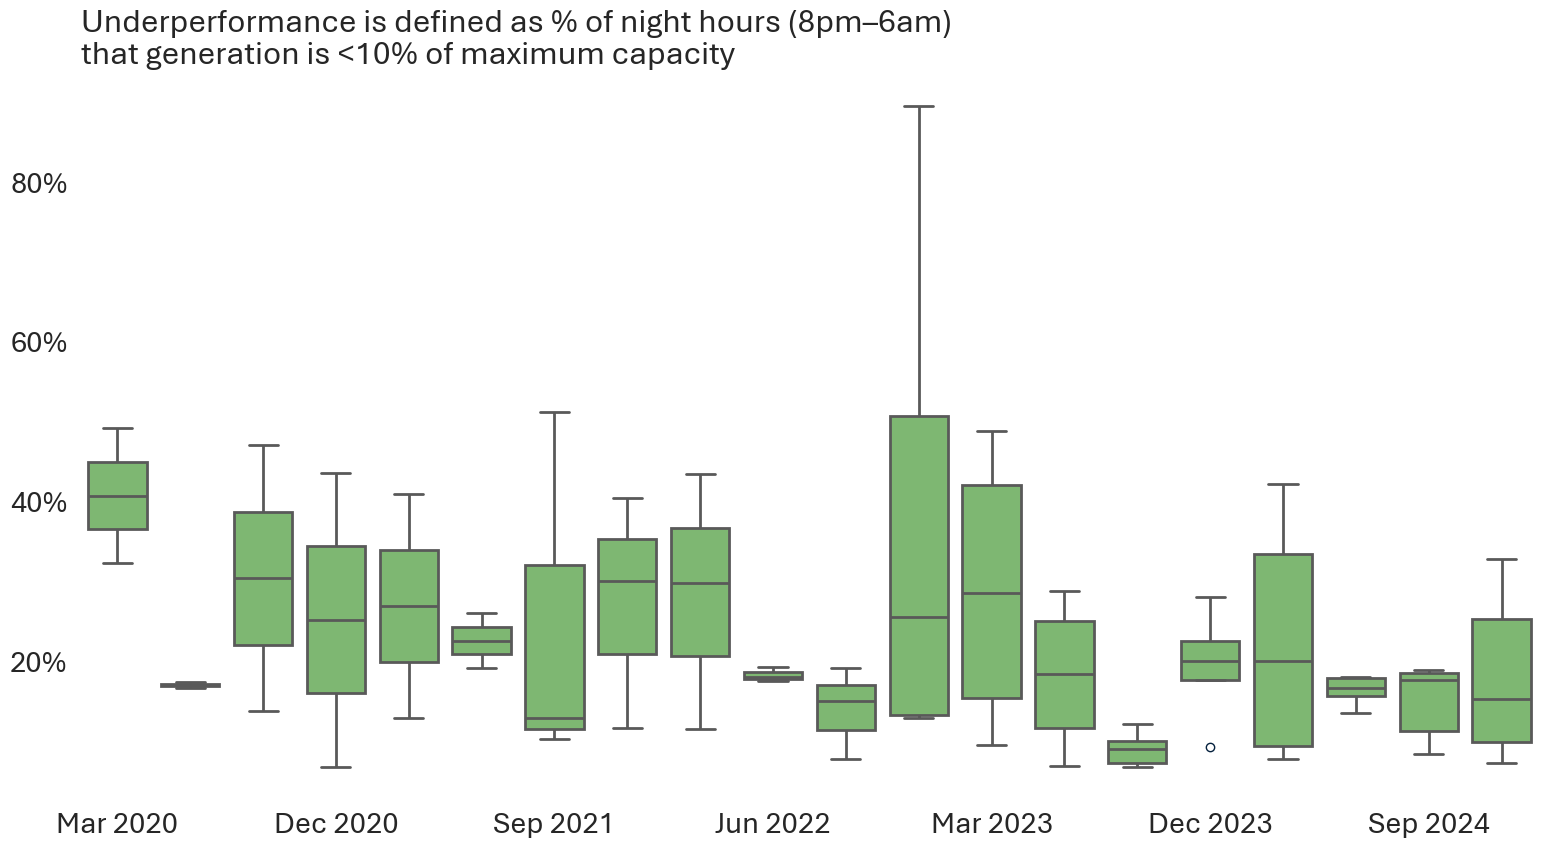

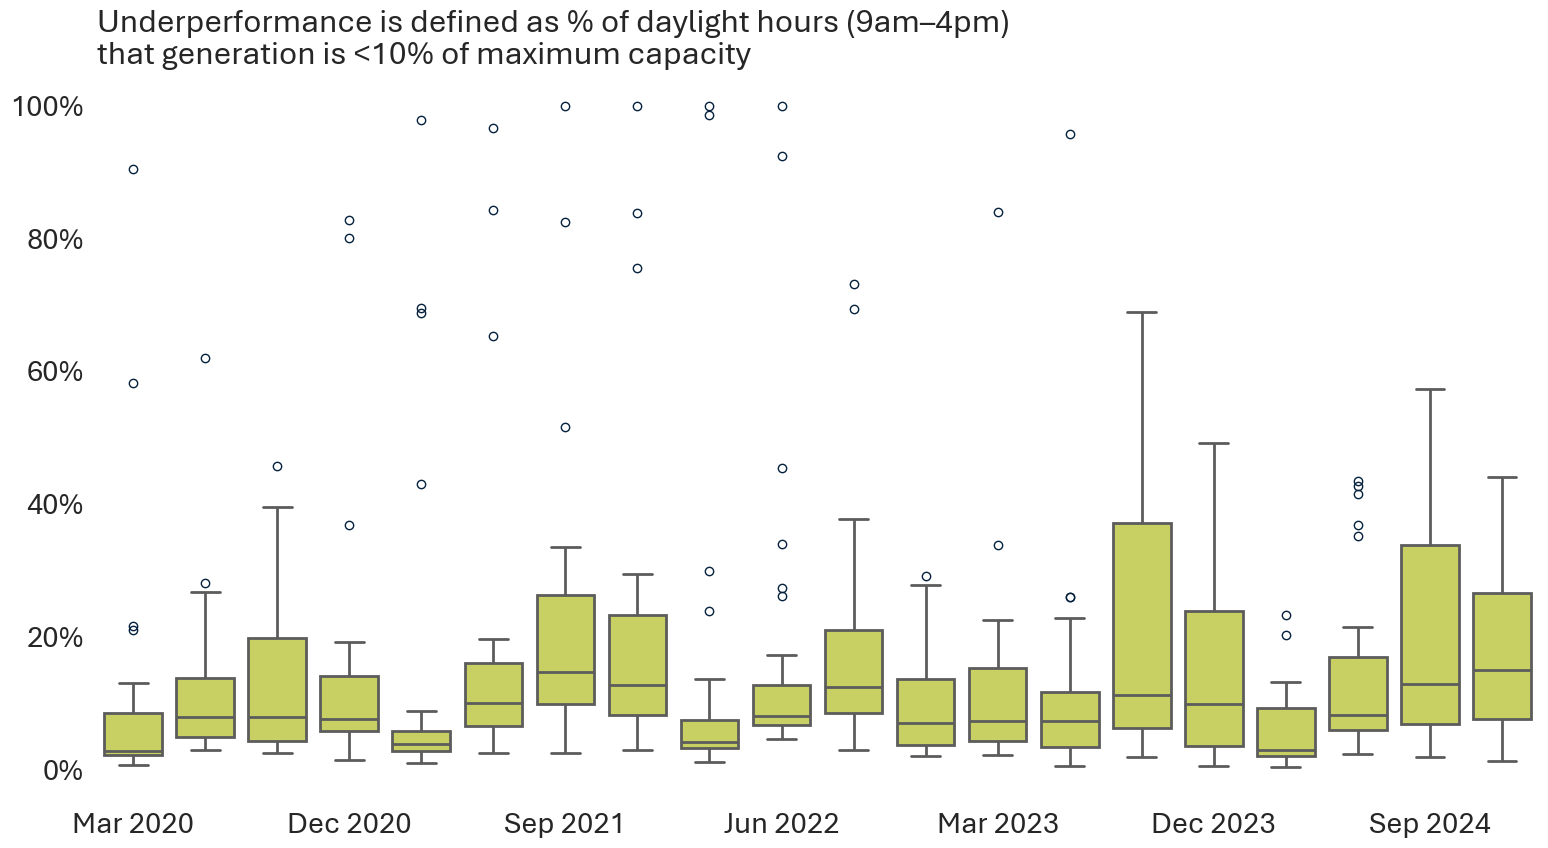

SA


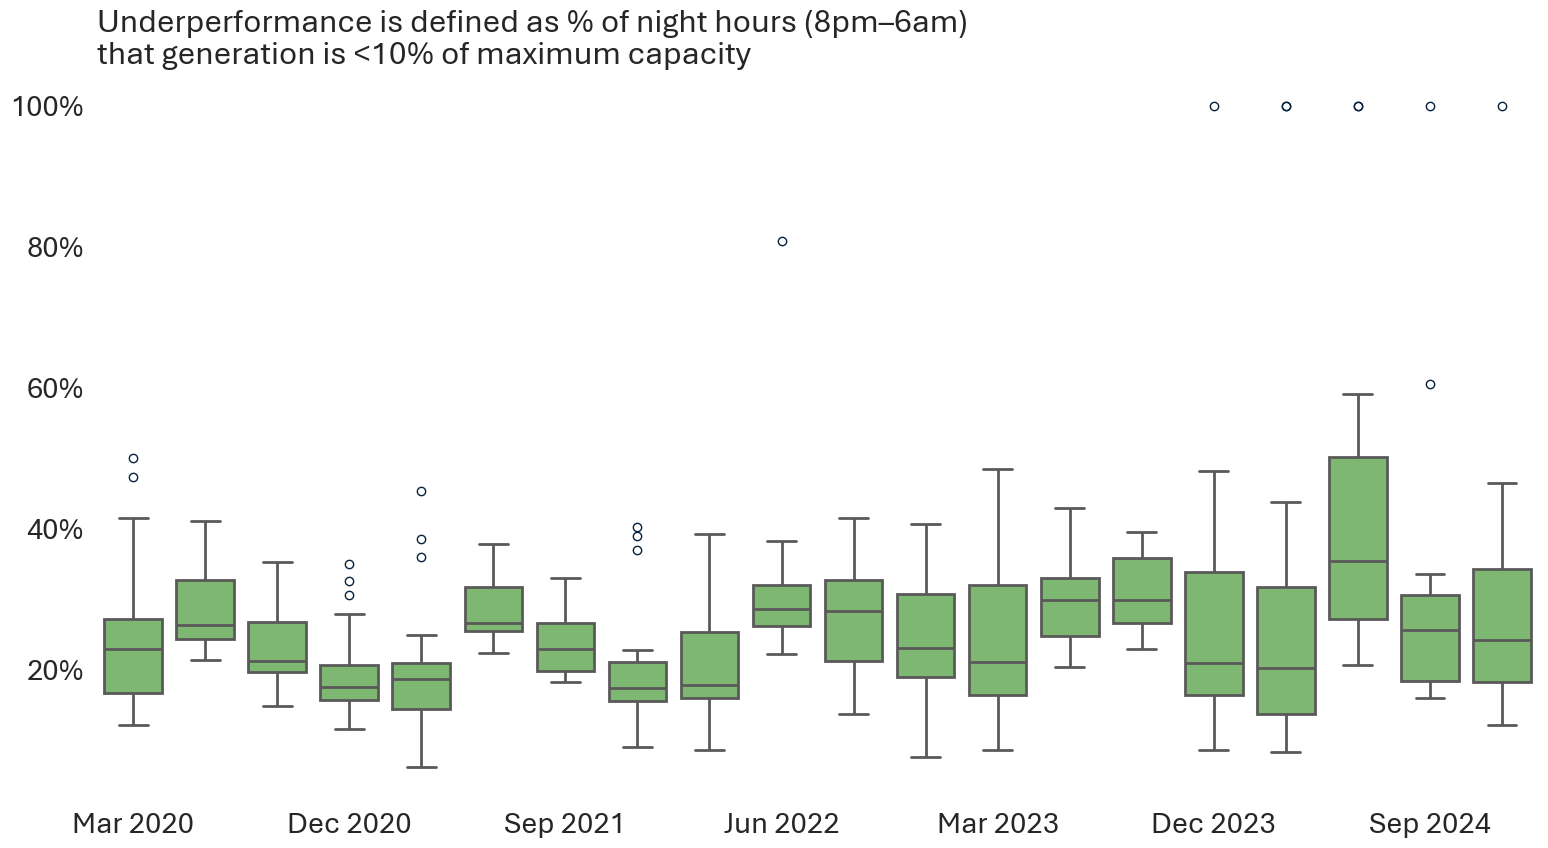

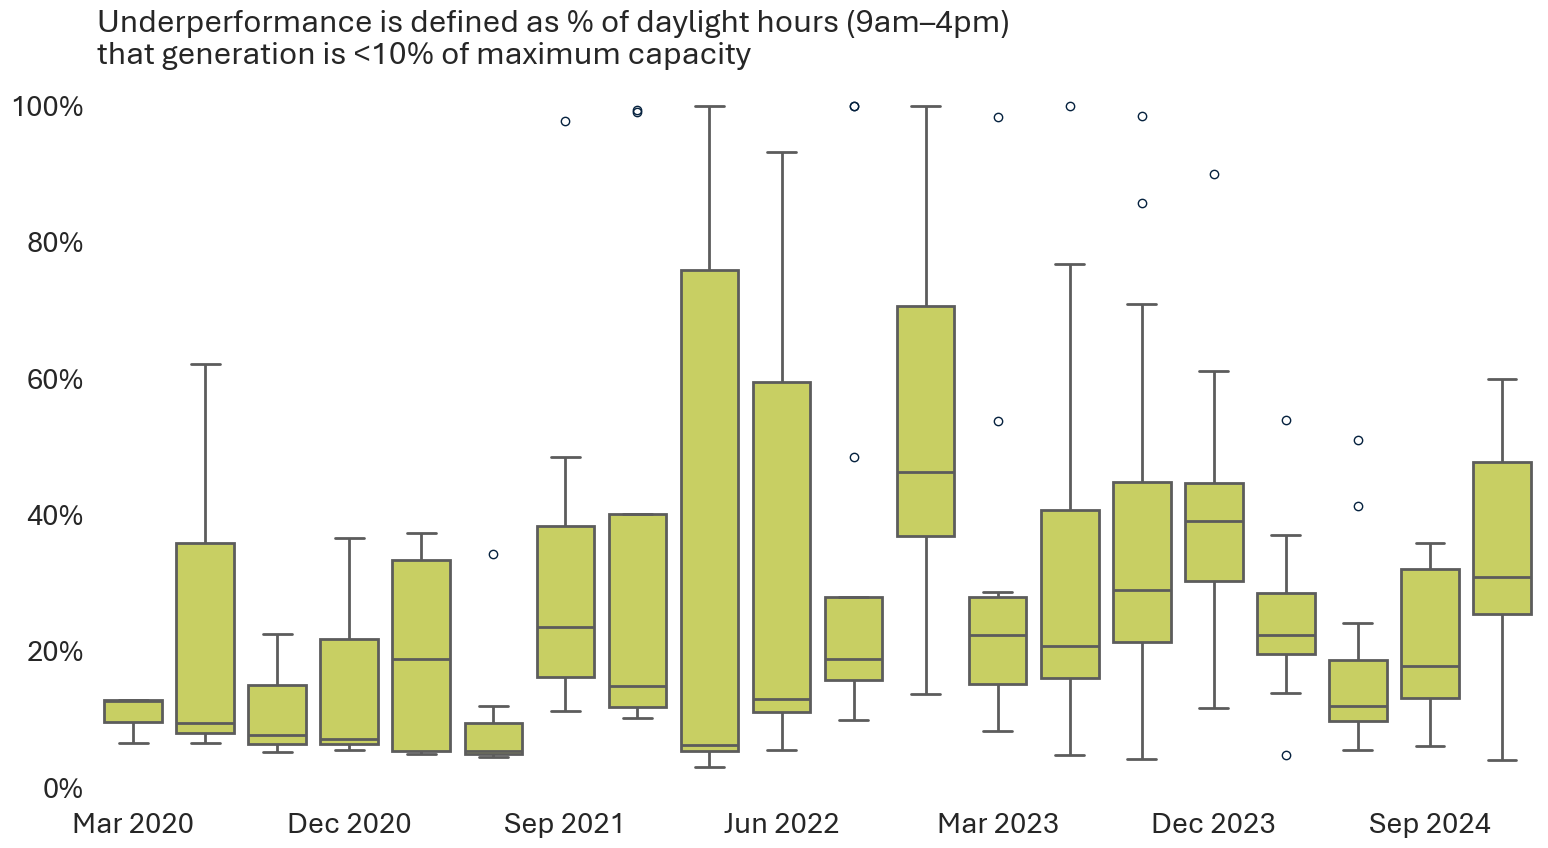

VIC


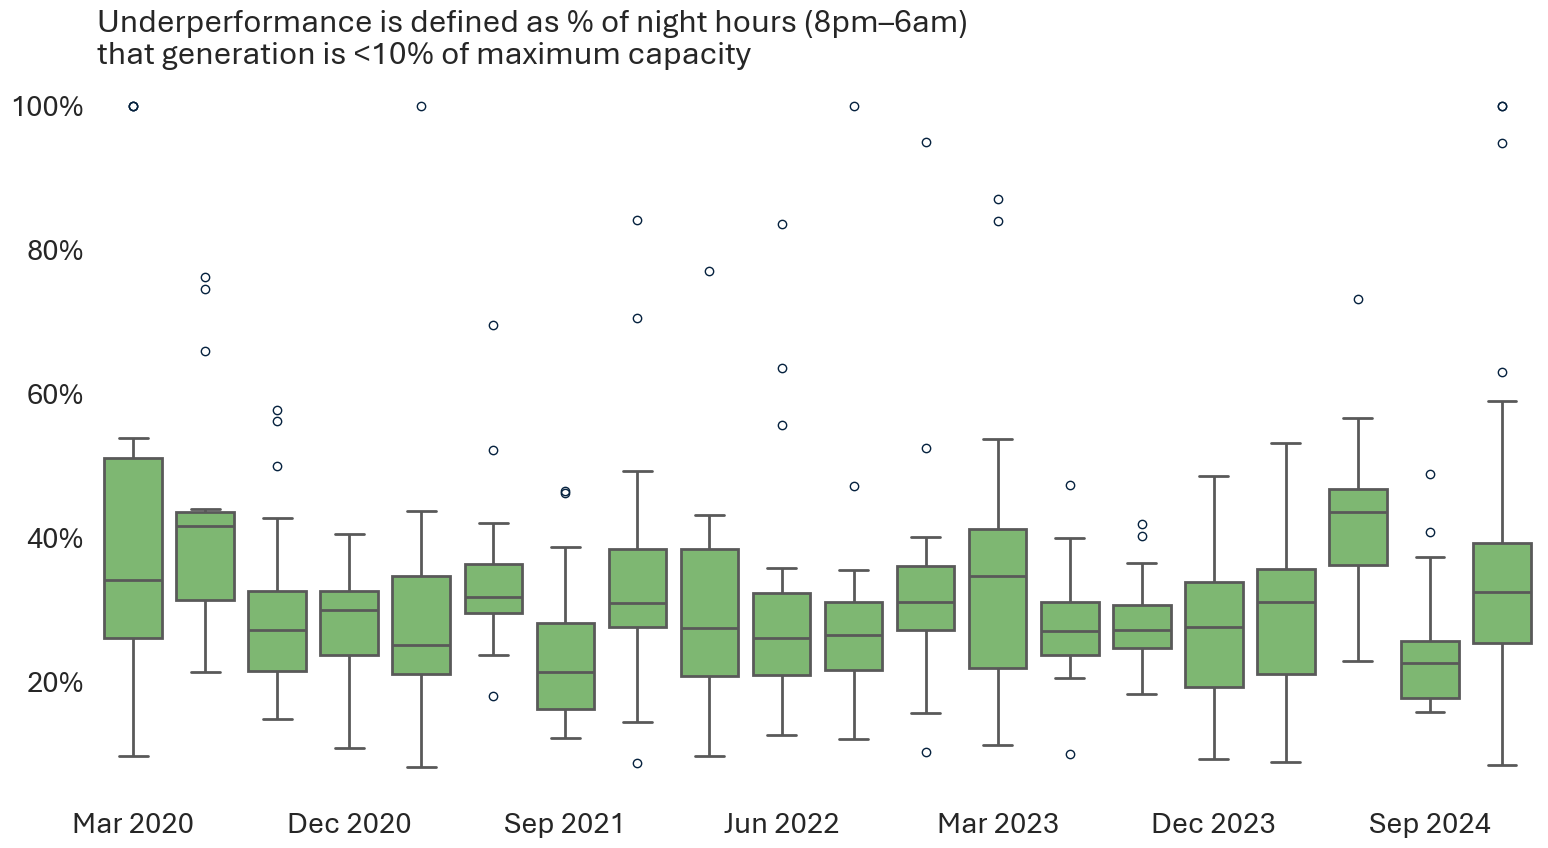

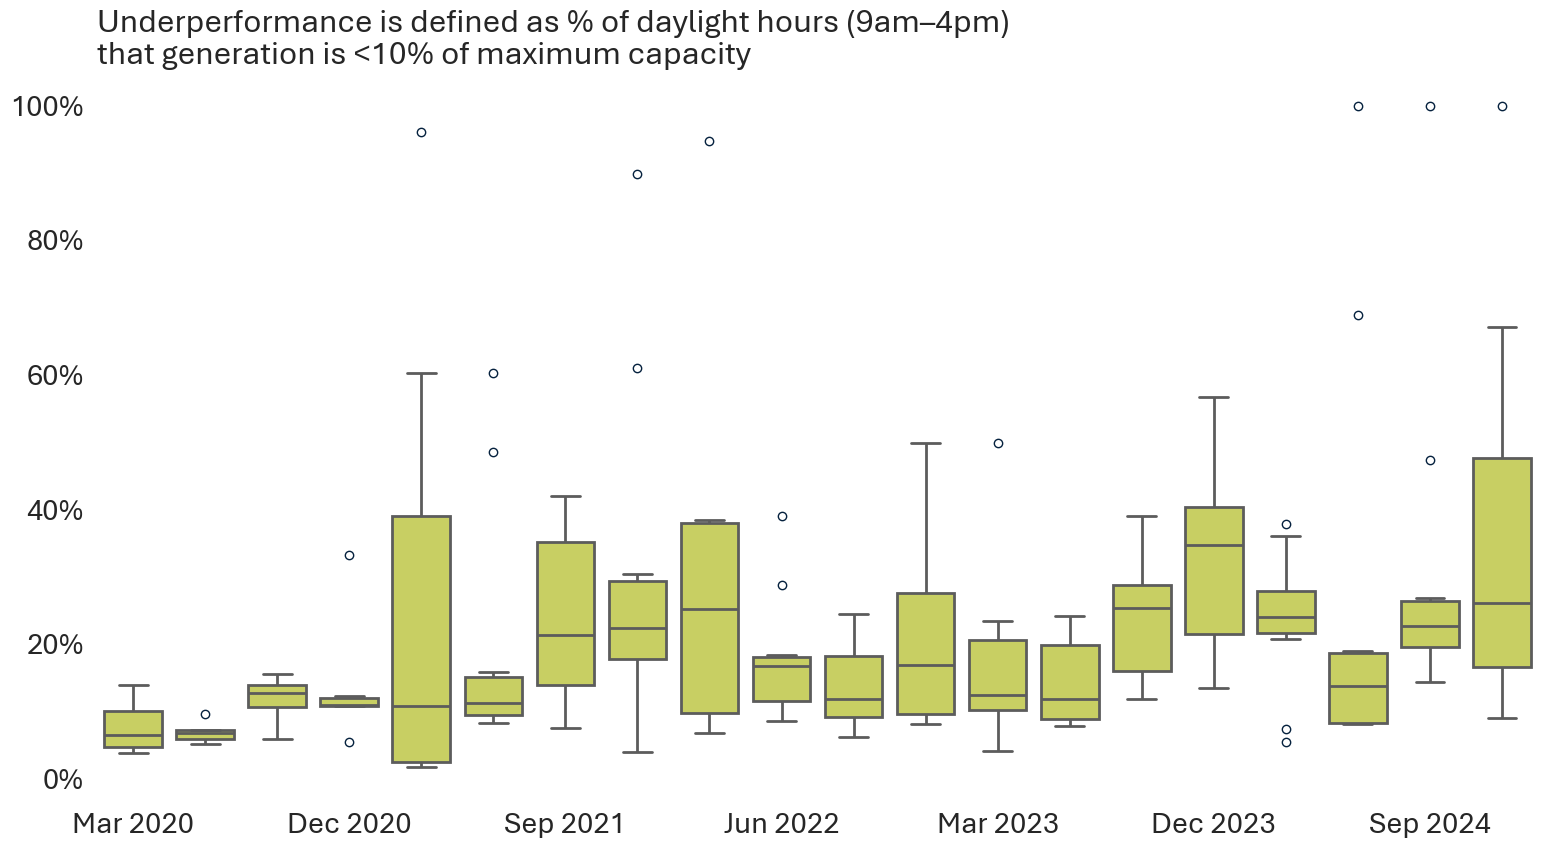

In [7]:
for i, region in enumerate(regions):
    print(region)
    for tech in ["Wind", "Solar"]:
        region_duids = gen_info[
            (gen_info["Region"] == region) &
            (gen_info["Technology"] == tech)].index
        region_data = pd.read_parquet(
            duid_data_path,
            engine="pyarrow",
            filters=[("DUID", "in", region_duids)],
            columns=["Interval", "DUID", "Output", "Maximum capacity"])
        if tech == "Wind":
            region_data = region_data[
                (region_data["Interval"].dt.hour < 6) |
                (region_data["Interval"].dt.hour > 20) |
                ((region_data["Interval"].dt.hour == 20) &
                (region_data["Interval"].dt.minute > 0))]
        else:
            region_data = region_data[
                ((region_data["Interval"].dt.hour < 16) &
                 (region_data["Interval"].dt.hour > 9)) |
                ((region_data["Interval"].dt.hour == 9) &
                 (region_data["Interval"].dt.minute > 0))]
        region_data["Underperformance"] = region_data["Output"] < (region_data["Maximum capacity"] * 0.1)
        region_data = region_data.pivot_table(
            index="Interval",
            columns="DUID",
            values="Underperformance",
            aggfunc="sum")
        region_data = region_data.resample("QE").mean()
        region_data.index.name = "Quarter"
        quarters = region_data.index
        first_row = region_data.iloc[0]    
        # Filter out invalid sequences
        region_data_valid = region_data.shift(1).notna()
        region_data = region_data.where(region_data_valid)
        region_data.iloc[0] = first_row

        # Melt for boxplot
        box_data = region_data.reset_index().melt(
            id_vars="Quarter",
            var_name="DUID",
            value_name="Underperformance")
        region_data.to_csv(
            os.path.join(data_dir, f"{region}_duid_{tech.lower()}_underperformance_quarterly.csv"))

        # Create plot
        fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)

        # Create boxplot
        sns.boxplot(
            ax=ax,
            data=box_data,
            x="Quarter",
            y="Underperformance",
            color=("C3" if tech == "Wind" else "C4"),
            linewidth=2,
            flierprops=dict(markeredgecolor="C0"))

        # Format axes
        ax.set_xticks(ax.get_xticks()[::3])
        ax.set_xticklabels([f"{quarters[t]:%b %Y}" for t in ax.get_xticks()])
        ax.yaxis.set_major_formatter(lambda x, p: f"{x:.0%}")

        # Clean up
        for frame in ["top", "right", "bottom", "left"]:
            ax.spines[frame].set_visible(False)

        plt.ylabel(None)
        plt.xlabel(None)
        plt.title(f"Underperformance is defined as % of {'night hours\n(8pm–6am)' if tech == 'Wind' else 'daylight hours\n(9am–4pm)'} that generation is <10% of maximum capacity", loc="left")
        plt.show()
        save_figure(fig, f"{region}_duid_{tech.lower()}_quarterly_underperformance", charts_dir)